# Predicting Startup Exits

Ultimately, every startup journey ends in some kind of an exit. Broadly speaking, this can be an IPO, an acquisition, a closure or the business can continue operating indefinetly as a private business. Being able to predict whether a company is likely to achieve an IPO or acquisition (what I term as a positive exit) is valuable information for almost all stakeholders involved in the entrepreneurial ecosystem. In particular, this information is likely to be extremely useful to:

 * Founders as an exit offers the chance to cash in years of hard work (usually accumulated as equity holdings) 
 * Venture Capital firms as predicting company exits is simply how they make their money (or not)
 * Support organizations such as incubators, innovation hubs aiming to strategically serve entrepreneurial communities
 
Other stakeholders too can derive some value from this kind of information. For example, employees of startups cna use this information to assess the value of their stock options. In the past, early employees of notable startups have turned into overnight millionaires when their respective employers IPO'd, (think Google, Microsoft, etc.). 

Depending on the results, this exercise could also have implications for the Venture Capital community and benchmarking a fund's performance. Consider the situation where our algorithm is able to make predictions with an accuracy of 60% as to whether it will be acquired or have a successful ipo eventually. Let's say VCs in comparison are only able to do so 30% of the time. (Historically, venture capital as an asset class has generated poor returns although exact numbers are disputed). This naturally would put to question the role of VCs in the entreprenurial ecosystem and the value that they truly add. To put it more generally, if we find that machine learning techniques do:  
 * Just as badly as VCs, one can't really blame VCs
 * Worse than VCs, VCs get validation for their role in the entrepreneurial ecosystem
 * Better than VCs, VCs will get shutdown similar to how stock indexes have taken out the managed funds (e.g. mutual funds) industry. 

# The problem

Predicting startup exits is a tricky business, even for clever humans! https://www.wsj.com/news/articles/SB10000872396390443720204578004980476429190  

The difficulty stems partly from the fact that startups can fail for a great variety of reasons: 
 * Ahead of their time/market not ready  
 * Bad founders  
 * Founders lack connections to scale  
 * Technology failure
 * Etc. 

Sometimes, even if a startup ticks all of the above boxes, a founder may not want to exit i.e. they may wish to continue running the firm as a privately owned business! This too from a VC perspective is a negative outcome as dividends return money too slowly (usually) for a VC's timescale. 

Another reason why this exercise has been a difficult one for machine learning is because data on startups has been hard to come by in significnant quantities. As startups are typically not obligated to record and make public their financial statements and also because many founders like to behave secretively, useful information (i.e. information with predictive value) is difficult to come by.  

# The solution

Today we have access to a vast body of information on thousands of startups from across the globe through CrunchBase, a largest public database. There is a strong possibility that this information can be mined for predicting startup exits. 

Essentially, our task is a classification problem. We will attempt to explore a few financial variables within several classification machine learning frameworks:
 * Multinomial Naive Bayes
 * KNN
 * SVM
 * Decision trees
 * Random Forests
 * Gradient boosted classifiers
 * XGBoost
 * AdaBoost
 * Ensemble  

The only question that remains is at what age we want to be able to classify companies as either positive exits or negative exits. We define this below. 

In [1]:
age_cutoff = 3

Before we get started, let's load the usual libraries we'll need throughout this notebook.  
We'll load other libraries/function as their need arises. 

In [2]:
# Load basic libraries
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from ggplot import *

import matplotlib.dates as dates
import datetime

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup plots
%matplotlib inline 
#plt.style.use('fivethirtyeight')

# Data Collection

CrunchBase provides access to a snapshot of the data it had collected up until the end of 2013 freely.  
This data is provided as SQL dumps.   
I simply took the SQL dumps, loaded them into a MySQL database and exported them as csv sheets which is what we read into python below. 

In [3]:
# load data 

try:
    cb_funding_rounds

except NameError:

    # funding
    temp_path = '/Users/fqaiser/Box Sync/fqaiser/Springboard/Capstone/csv/cb_funding_rounds.csv'
    cb_funding_rounds = pd.read_csv(temp_path)

    # objects
    temp_path = '/Users/fqaiser/Box Sync/fqaiser/Springboard/Capstone/csv/cb_objects.csv'
    cb_objects = pd.read_csv(temp_path)

    # offices 
    temp_path = '/Users/fqaiser/Box Sync/fqaiser/Springboard/Capstone/csv/cb_offices.csv'
    cb_offices = pd.read_csv(temp_path)

    # funds
    temp_path = '/Users/fqaiser/Box Sync/fqaiser/Springboard/Capstone/csv/cb_funds.csv'
    cb_funds = pd.read_csv(temp_path)

    # relationships
    temp_path = '/Users/fqaiser/Box Sync/fqaiser/Springboard/Capstone/csv/cb_relationships.csv'
    cb_relationships = pd.read_csv(temp_path)

    # milestones 
    temp_path = '/Users/fqaiser/Box Sync/fqaiser/Springboard/Capstone/csv/cb_milestones.csv'
    cb_milestones = pd.read_csv(temp_path)

    # investments
    temp_path = '/Users/fqaiser/Box Sync/fqaiser/Springboard/Capstone/csv/cb_investments.csv'
    cb_investments = pd.read_csv(temp_path)
    
    # IPOs
    temp_path = '/Users/fqaiser/Box Sync/fqaiser/Springboard/Capstone/csv/cb_ipos.csv'
    cb_ipos = pd.read_csv(temp_path)
    
    # acquisitions
    temp_path = '/Users/fqaiser/Box Sync/fqaiser/Springboard/Capstone/csv/cb_acquisitions.csv'
    cb_acquisitions = pd.read_csv(temp_path)

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3,7,9,10,17,18,21,22,23,25,26,29,30,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Initial sample of startups
I start off bulding my dataset by choosing all the startups that were founded before 2009.  

Why founded before 2009?
Because we chose the age cut off to be at 5 years, we want to make sure that all the startups in our sample have at least 5 years of data.  

In [4]:
# create initial list of companies we care about
a = cb_objects[['id', 'entity_type', 'name', 'category_code', 'status', 'founded_at', 'country_code', 'region', 'twitter_username', 'homepage_url']]

# entity_type can be ['Company', 'FinancialOrg', 'Person', 'Product']
# we only want companies naturally
a = a[a.entity_type=='Company']

# filter out companies for which we don't have a founding date
a = a[a.founded_at.notnull()]

# we only want companies were founded before 2009 started
a.founded_at = pd.to_datetime(a.founded_at)
a = a[(a.founded_at <= '2009-01-01')]

Next we refine this list further by choosing only startups that are located in countries that have at least 500 startups listed on CrunchBase. Notably missing from this list is Germany. This is possibly because Germany is a relative newcomer to the startup scene. 

In [5]:
temp = a

temp = temp.groupby(by = ['country_code']).id.nunique().reset_index()
temp.rename(columns={'id': 'Amount'}, inplace=True)
temp = temp.sort_values(by = 'Amount', ascending = False)
temp = temp[temp.Amount>500]

temp

,country_code,Amount
139,USA,23575
49,GBR,3050
24,CAN,1631
60,IND,1476
47,FRA,768
37,DEU,738
9,AUS,567


In [6]:
# filter for countries where we have more than 500 samples
a = a[a.country_code.isin(temp.country_code)]

a.head()

,id,entity_type,name,category_code,status,founded_at,country_code,region,twitter_username,homepage_url
0,c:1,Company,Wetpaint,web,operating,2005-10-17,USA,Seattle,BachelrWetpaint,http://wetpaint-inc.com
6,c:10003,Company,Green Basti Ecosystems,cleantech,operating,2008-08-20,IND,Vadodara,NaN,NaN
12,c:10009,Company,dimension5 labs,advertising,operating,2008-08-01,USA,Santa Fe,NaN,http://d5labs.com
13,c:1001,Company,FriendFeed,web,acquired,2007-10-01,USA,SF Bay,friendfeed,http://friendfeed.com
15,c:10011,Company,PoetryVisualized.com,games_video,operating,2008-01-01,USA,San Diego,NaN,http://www.poetryvisualized.com


Next we take a closer look at the category codes in our dataset. 

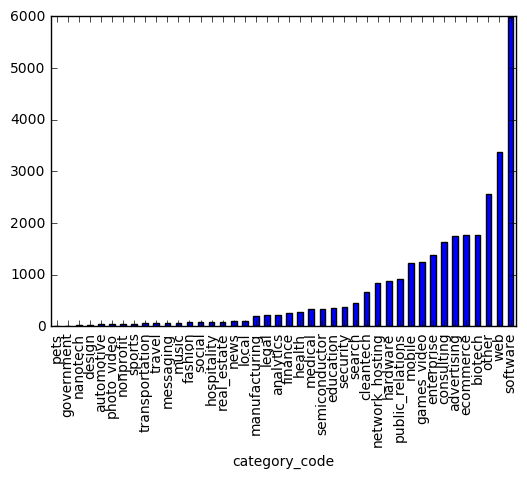

In [7]:
a.groupby('category_code').size().sort_values().plot(kind="bar")

As you can see, we have a fairly long tail.  
Let's try to consolidate some of these categories so that categories with similar product lifecycles are grouped together.

In [8]:
category = {'pets': 'other',
            'other': 'other',
            'government': 'other',
            'nanotech': 'other',
            'automotive': 'other',
            'local': 'other',
            'nonprofit': 'other',
            np.nan: 'other',
            'manufacturing': 'other',
            'travel': 'other',
            'transportation': 'other',
            'hospitality': 'other', 
            
            'consulting': 'service',
            'design': 'service',
            'real_estate': 'service',
            'public_relations': 'service',
            'network_hosting': 'service',
            
            'games_video': 'media',
            'photo_video': 'media',
            'music': 'media',
            'news': 'media',
            
            'sports': 'sports',
            
            'web': 'internet',
            'advertising': 'internet',
            'ecommerce': 'internet',
            'fashion': 'internet',
            
            'software': 'software',
            'mobile': 'software',
            'enterprise': 'software',
            
            'health': 'health',
            'biotech': 'health',
            'medical': 'health',
            
            'social': 'social',
            'messaging': 'social',
            
            'cleantech': 'cleantech',
            
            'semiconductor': 'hardware',
            'hardware': 'hardware',
            
            'analytics': 'analytics',
            
            'finance': 'fintech',
            
            'legal': 'legal',
            
            'education': 'edtech',
            
            'security': 'security',
            
            'search': 'search'}

category = pd.DataFrame(list(category.items()),
                        columns=['category_code','category'])
category.head()

,category_code,category
0,NaN,other
1,local,other
2,pets,other
3,automotive,other
4,travel,other


In [9]:
a = pd.merge(a, category, left_on='category_code', right_on='category_code', how = 'left')
a.drop(['category_code'], axis=1, inplace=True)
a.head()

,id,entity_type,name,status,founded_at,country_code,region,twitter_username,homepage_url,category
0,c:1,Company,Wetpaint,operating,2005-10-17,USA,Seattle,BachelrWetpaint,http://wetpaint-inc.com,internet
1,c:10003,Company,Green Basti Ecosystems,operating,2008-08-20,IND,Vadodara,NaN,NaN,cleantech
2,c:10009,Company,dimension5 labs,operating,2008-08-01,USA,Santa Fe,NaN,http://d5labs.com,internet
3,c:1001,Company,FriendFeed,acquired,2007-10-01,USA,SF Bay,friendfeed,http://friendfeed.com,internet
4,c:10011,Company,PoetryVisualized.com,operating,2008-01-01,USA,San Diego,NaN,http://www.poetryvisualized.com,media


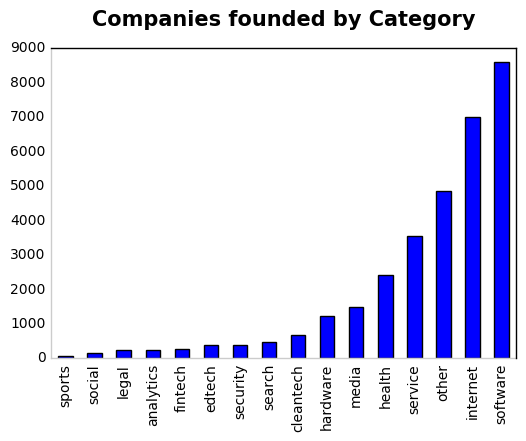

In [10]:
ax = a.groupby('category').size().sort_values().plot(kind="bar")

ax.legend().set_visible(False)

ax.tick_params(axis=u'both', which=u'both',length=0)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)

ax.set_title("Companies founded by Category", fontweight = 'bold', fontsize = 15, position = [.5,1.05])
ax.set_ylabel("", fontsize = 12, fontstyle = 'italic')
ax.set_xlabel("", fontsize = 12, fontstyle = 'italic')

That looks much better.  
Now let's have a look at how many companies are founded each year in our dataset.  

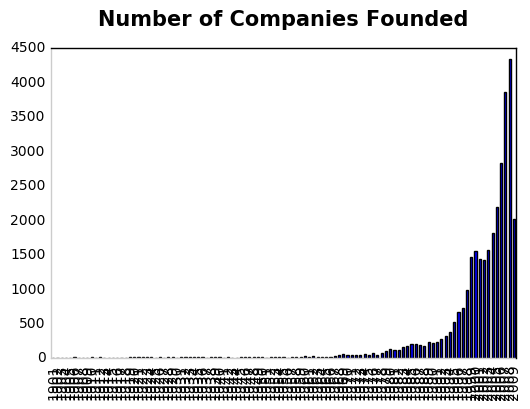

In [11]:
temp = a.groupby(by = [a.founded_at.dt.year]).id.nunique().reset_index()
temp.rename(columns={'id': 'Amount'}, inplace=True)
ax = temp.plot(x = 'founded_at', y = 'Amount', rot = 90, kind = 'bar')

ax.legend().set_visible(False)

ax.tick_params(axis=u'both', which=u'both',length=0)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)

ax.set_title("Number of Companies Founded", fontweight = 'bold', fontsize = 15, position = [.5,1.05])
ax.set_ylabel("", fontsize = 12, fontstyle = 'italic')
ax.set_xlabel("", fontsize = 12, fontstyle = 'italic')

While the data appears to imply that entrepreneurship is a recent fad, you have to keep in mind the fact that CrunchBase itself was only founded in 2007. Its likely that data points before 2007 are significantly under represented.  

The dramatic drop in 2009 should also be interpreted cautiously. Since this data comes from a snapshot of the CrunchBase dataset back in December 2013, its likely that many founders of newer startups may not have yet listed their companies on CrunchBase. 

Lastly, let's see the distribution of companies between IPOs, acquisitions, closure and operating. 

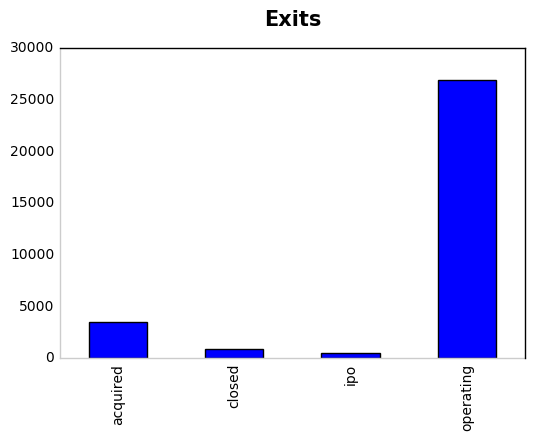

In [12]:
temp = a.groupby(by = [a.status]).id.nunique().reset_index()
temp.rename(columns={'id': 'Amount'}, inplace=True)
ax = temp.plot(x = 'status', y = 'Amount', rot = 90, kind = 'bar')

ax.legend().set_visible(False)

ax.tick_params(axis=u'both', which=u'both',length=0)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)

ax.set_title("Exits", fontweight = 'bold', fontsize = 15, position = [.5,1.05])
ax.set_ylabel("", fontsize = 12, fontstyle = 'italic')
ax.set_xlabel("", fontsize = 12, fontstyle = 'italic')

The number of closed companies is likely to be highly underrepresented in our sample and a large portion of operating companies will likely classify as closed. While this would normally be a problem, for our purposes it does not matter since both operating companies and closed companies will be treated as negative outcomes. Our positive outcomes are those companies that have been acquired or IPO'd. 

What's immediately obvious from the above picture is that our data is significaly imbalanced. Generally speaking, machine learning techniques work best with balanced datasets. We'll have to keep this in mind when we get to that stage.  

Let's take a look at the data we've collected so far. 

In [13]:
# add to final dataset
all_data = a

all_data.head()

,id,entity_type,name,status,founded_at,country_code,region,twitter_username,homepage_url,category
0,c:1,Company,Wetpaint,operating,2005-10-17,USA,Seattle,BachelrWetpaint,http://wetpaint-inc.com,internet
1,c:10003,Company,Green Basti Ecosystems,operating,2008-08-20,IND,Vadodara,NaN,NaN,cleantech
2,c:10009,Company,dimension5 labs,operating,2008-08-01,USA,Santa Fe,NaN,http://d5labs.com,internet
3,c:1001,Company,FriendFeed,acquired,2007-10-01,USA,SF Bay,friendfeed,http://friendfeed.com,internet
4,c:10011,Company,PoetryVisualized.com,operating,2008-01-01,USA,San Diego,NaN,http://www.poetryvisualized.com,media


## Additional details

Choosing informative, discriminating and independent features is a crucial step for effective algorithms in classification. So far we've collected only 3 features about each startup; 
 * the year they were founded
 * which country they're based in and 
 * which category/sector they operate in

Before we try to get more data, we need to set up some code infrastructure. You see, CrunchBase has provided us with all the data that it has to date for each startup. However, we only want the data for each startup up till when reached 3 years of age. These next few pieces of code are aimed at setting up the infrastructure to do this easily.  

In [14]:
from dateutil.relativedelta import  relativedelta

age_lookup = a
age_lookup['cut_off_date'] = age_lookup.founded_at.apply(lambda x: x + relativedelta(years = age_cutoff))
age_lookup = age_lookup[['id', 
                         #'name', 
                         #'founded_at', 
                         'cut_off_date']]
age_lookup.head()

,id,cut_off_date
0,c:1,2008-10-17
1,c:10003,2011-08-20
2,c:10009,2011-08-01
3,c:1001,2010-10-01
4,c:10011,2011-01-01


In [15]:
def closest_date(df, date_col, object_id_col = 'object_id', lookup_table = age_lookup):
    df = pd.merge(df, lookup_table, how='left', left_on = object_id_col, right_on = 'id')
    df = df.sort_values(by = [object_id_col, date_col], ascending = True)
    df = df[df[date_col] < df['cut_off_date']]
    df = df.groupby(by = [object_id_col]).tail(1).drop(['id', 'cut_off_date', date_col], axis = 1)
    
    return(df)

Now that we've done that, we can start collecting additional details about each startup up until they reach 3 years of age.  

## Offices
Let's start by collecting office data. 

In [16]:
b = cb_offices
b.head()

,id,object_id,office_id,description,region,address1,address2,city,zip_code,state_code,country_code,latitude,longitude,created_at,updated_at
0,1,c:1,1,NaN,Seattle,710 - 2nd Avenue,Suite 1100,Seattle,98104,WA,USA,47.603122,-122.333253,NaN,NaN
1,2,c:3,3,Headquarters,SF Bay,4900 Hopyard Rd,Suite 310,Pleasanton,94588,CA,USA,37.692934,-121.904945,NaN,NaN
2,3,c:4,4,NaN,SF Bay,135 Mississippi St,NaN,San Francisco,94107,CA,USA,37.764726,-122.394523,NaN,NaN
3,4,c:5,5,Headquarters,SF Bay,1601 Willow Road,NaN,Menlo Park,94025,CA,USA,37.416050,-122.151801,NaN,NaN
4,5,c:7,7,NaN,SF Bay,Suite 200,654 High Street,Palo Alto,94301,CA,ISR,NaN,NaN,NaN,NaN


In [17]:
# grab number of offices 
b = cb_offices.groupby(by = [cb_offices.object_id]).office_id.nunique().reset_index()
b.rename(columns={'office_id': 'offices'}, inplace=True)

b.head()

,object_id,offices
0,c:1,2
1,c:10,1
2,c:100,1
3,c:10002,2
4,c:10003,1


In [18]:
# number of offices
all_data = pd.merge(all_data, b, how='left', left_on = 'id', right_on = 'object_id')
all_data.drop('object_id', axis=1, inplace=True)

all_data['offices'] = np.where((all_data.offices.isnull()), 1, all_data['offices'])

all_data.head()

,id,entity_type,name,status,founded_at,country_code,region,twitter_username,homepage_url,category,cut_off_date,offices
0,c:1,Company,Wetpaint,operating,2005-10-17,USA,Seattle,BachelrWetpaint,http://wetpaint-inc.com,internet,2008-10-17,2
1,c:10003,Company,Green Basti Ecosystems,operating,2008-08-20,IND,Vadodara,NaN,NaN,cleantech,2011-08-20,1
2,c:10009,Company,dimension5 labs,operating,2008-08-01,USA,Santa Fe,NaN,http://d5labs.com,internet,2011-08-01,1
3,c:1001,Company,FriendFeed,acquired,2007-10-01,USA,SF Bay,friendfeed,http://friendfeed.com,internet,2010-10-01,1
4,c:10011,Company,PoetryVisualized.com,operating,2008-01-01,USA,San Diego,NaN,http://www.poetryvisualized.com,media,2011-01-01,1


Disappointingly, we don't have dates associated with office buildings.  
Using this data to predict whether a company will have a positive exit outcome would mean that future data will bleed into our dataset. Using future data to predict the future hardly sounds like a useful exercise. We'll need to remembr to remove this data in a later step before we dive into machine learning. 

# Board, Employees & Founders

Next, lets collect data about the number of board members, employees and founders each startup has. 

In [19]:
c = cb_relationships
c.head()

,id,relationship_id,person_object_id,relationship_object_id,start_at,end_at,is_past,sequence,title,created_at,updated_at
0,1,1,p:2,c:1,NaN,NaN,0,8,Co-Founder/CEO/Board of Directors,2007-05-25 07:03:54,2013-06-03 09:58:46
1,2,2,p:3,c:1,NaN,NaN,1,279242,VP Marketing,2007-05-25 07:04:16,2010-05-21 16:31:34
2,3,3,p:4,c:3,NaN,NaN,0,4,Evangelist,2007-05-25 19:33:03,2013-06-29 13:36:58
3,4,4,p:5,c:3,2006-03-01,2009-12-01,1,4,Senior Director Strategic Alliances,2007-05-25 19:34:53,2013-06-29 10:25:34
4,6,6,p:7,c:4,2005-07-01,2010-04-05,1,1,Chief Executive Officer,2007-05-25 20:05:33,2010-04-05 18:41:41


In [20]:
# grab number of founders, employees, board members
c = cb_relationships
c.start_at = pd.to_datetime(c.start_at)
c.end_at = pd.to_datetime(c.end_at)
c = c[['person_object_id', 'relationship_object_id', 'start_at','title']]

# if title is board member
c.loc[c["title"].str.contains('board', case=False, na=False), 'Category'] = 'board'

# otherwise if title includes founder
c.loc[c["title"].str.contains('founder', case=False, na=False), 'Category'] = 'founders'

# otherwise employee
c.loc[c.Category.isnull(), 'Category'] = 'employees'

# cut-off date function
c_temp = c
c = closest_date(c, date_col='start_at', object_id_col='relationship_object_id')

# spread values
c = c.groupby(by = [c.relationship_object_id, c.Category]).person_object_id.nunique().reset_index()
c.rename(columns={'person_object_id': 'count'}, inplace=True)
c = c.pivot_table(index='relationship_object_id', columns='Category', values='count').reset_index()

c_temp = c_temp.groupby(by = ['relationship_object_id', 'Category']).person_object_id.nunique().reset_index()

# founders should have been there from the beginning technically so we don't want to apply cut-off function there
c = c.drop('founders', axis=1)
c1 = cb_relationships
c1 = c1[['person_object_id', 'relationship_object_id', 'start_at','title']]

c1.loc[c1["title"].str.contains('founder', case=False, na=False), 'Category'] = 'founders'

c1 = c1.groupby(by = ['relationship_object_id', 'Category']).person_object_id.nunique().reset_index()
c1.rename(columns={'person_object_id': 'count'}, inplace=True)
c1 = c1.pivot_table(index='relationship_object_id', columns='Category', values='count').reset_index()

# bring founders together with employees and board
c = pd.merge(c, c1, how='outer', left_on = 'relationship_object_id', right_on = 'relationship_object_id')

c.head()

//anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Category,relationship_object_id,board,employees,founders
0,c:1,1.0,NaN,2.0
1,c:1001,NaN,1.0,4.0
2,c:10011,NaN,NaN,1.0
3,c:10014,NaN,1.0,1.0
4,c:10015,NaN,1.0,1.0


In [21]:
# add number of founders, employees, board members to all_data
all_data = pd.merge(all_data, c, how='left', left_on = 'id', right_on = 'relationship_object_id')
all_data.drop('relationship_object_id', axis=1, inplace=True)

# this is to replace some NULLS in board and employees columns with 0 because at 3 years of age most companies won't have put up information about board and employees on CrunchBase if they had none.
all_data['board'] = np.where((all_data.board.isnull()) & all_data.id.isin(c_temp.relationship_object_id) & (c_temp.Category=='board'), 0, all_data['board'])
all_data['employees'] = np.where((all_data.employees.isnull()) & all_data.id.isin(c_temp.relationship_object_id) & (c_temp.Category=='employees'), 0, all_data['employees'])
#all_data['founders'] = np.where((all_data.founders.isnull()) & all_data.id.isin(c_temp.relationship_object_id) & (c_temp.Category=='founders'), 1, all_data['founders'])

all_data.head()

,id,entity_type,name,status,founded_at,country_code,region,twitter_username,homepage_url,category,cut_off_date,offices,board,employees,founders
0,c:1,Company,Wetpaint,operating,2005-10-17,USA,Seattle,BachelrWetpaint,http://wetpaint-inc.com,internet,2008-10-17,2,1.0,NaN,2.0
1,c:10003,Company,Green Basti Ecosystems,operating,2008-08-20,IND,Vadodara,NaN,NaN,cleantech,2011-08-20,1,NaN,NaN,NaN
2,c:10009,Company,dimension5 labs,operating,2008-08-01,USA,Santa Fe,NaN,http://d5labs.com,internet,2011-08-01,1,NaN,NaN,NaN
3,c:1001,Company,FriendFeed,acquired,2007-10-01,USA,SF Bay,friendfeed,http://friendfeed.com,internet,2010-10-01,1,NaN,1.0,4.0
4,c:10011,Company,PoetryVisualized.com,operating,2008-01-01,USA,San Diego,NaN,http://www.poetryvisualized.com,media,2011-01-01,1,NaN,0.0,1.0


# Milestones

Next, let's grab data about the number of milestones each startup has achieved.  
A milestone, upon investigaton, tends to be each time a startup has been mentioned in the news for whatever achievement it's managed to do (or not do). Note, that this can just as easily be a technological milestones as a funding milestone. 

In [22]:
d = cb_milestones 
d.head()

,id,object_id,milestone_at,milestone_code,description,source_url,source_description,created_at,updated_at
0,1,c:12,2008-06-09,other,Survives iPhone 3G Stevenote,http://www.techcrunch.com/2008/06/10/twitter-f...,"Twitter Fails To Fail, Community Rejoices",2008-06-18 08:14:06,2008-06-18 08:14:06
1,2,c:3138,2008-06-17,other,Twhirl announces support for Seesmic video pla...,http://www.inquisitr.com/1103/seesmic-now-avai...,Seesmic Now Available In Twhirl,2008-06-18 08:46:28,2008-06-18 08:46:28
2,3,c:59,2008-06-18,other,More than 4 Billion videos viewed at Google Si...,http://www.comscore.com/press/release.asp?pres...,11 Billion Videos Viewed Online in the U.S. in...,2008-06-18 08:50:24,2008-06-18 08:50:24
3,4,c:314,2008-06-18,other,Reddit goes Open Source,http://blog.reddit.com/2008/06/reddit-goes-ope...,reddit goes open source,2008-06-19 04:14:00,2008-06-19 04:14:00
4,5,c:314,2008-01-22,other,Adds the ability to create your own Reddits,http://www.techcrunch.com/2008/01/22/reddit-ad...,Reddit Adds Ability to Create Your Own â€œRedd...,2008-06-19 04:15:53,2008-06-19 04:15:53


In [23]:
d = cb_milestones
d_temp = d

d.milestone_at = pd.to_datetime(d.milestone_at)
d = d.groupby(by = ['object_id', 'milestone_at']).id.nunique().groupby(level=[0]).cumsum().reset_index()
d.rename(columns={'id': 'milestones'}, inplace=True)

# cut-off date function
d = closest_date(d, 'milestone_at')

d.head(10)
#d_temp.head()

,object_id,milestones
3,c:10009,1
5,c:1001,2
6,c:10014,1
15,c:10071,2
18,c:10082,3
23,c:10106,1
30,c:10150,6
60,c:10176,8
62,c:10179,1
119,c:10376,1


In [24]:
# add number of milestones
all_data = pd.merge(all_data, d, how='left', left_on = 'id', right_on = 'object_id')
all_data.drop('object_id', axis=1, inplace=True)

# this is to replace NULLS with 0 because at age_cutoff some companies may not have achieved any milestones by that time but do later on
all_data['milestones'] = np.where((all_data.milestones.isnull()) & all_data.id.isin(d_temp.object_id), 0, all_data['milestones'])

all_data.head()

,id,entity_type,name,status,founded_at,country_code,region,twitter_username,homepage_url,category,cut_off_date,offices,board,employees,founders,milestones
0,c:1,Company,Wetpaint,operating,2005-10-17,USA,Seattle,BachelrWetpaint,http://wetpaint-inc.com,internet,2008-10-17,2,1.0,NaN,2.0,0.0
1,c:10003,Company,Green Basti Ecosystems,operating,2008-08-20,IND,Vadodara,NaN,NaN,cleantech,2011-08-20,1,NaN,NaN,NaN,NaN
2,c:10009,Company,dimension5 labs,operating,2008-08-01,USA,Santa Fe,NaN,http://d5labs.com,internet,2011-08-01,1,NaN,NaN,NaN,1.0
3,c:1001,Company,FriendFeed,acquired,2007-10-01,USA,SF Bay,friendfeed,http://friendfeed.com,internet,2010-10-01,1,NaN,1.0,4.0,2.0
4,c:10011,Company,PoetryVisualized.com,operating,2008-01-01,USA,San Diego,NaN,http://www.poetryvisualized.com,media,2011-01-01,1,NaN,0.0,1.0,NaN


# Number of funding events

Next we collect data about the number of funding events each company has had.  
My hypothesis is that those companies taht receive funding early are more likely to be those that achieve a positive exit later on.  

In [25]:
e = cb_funding_rounds
e.head()

,id,funding_round_id,object_id,funded_at,funding_round_type,funding_round_code,raised_amount_usd,raised_amount,raised_currency_code,pre_money_valuation_usd,pre_money_valuation,pre_money_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,participants,is_first_round,is_last_round,source_url,source_description,created_by,created_at,updated_at
0,1,1,c:4,2006-12-01,series-b,b,8500000.0,8500000.0,USD,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,http://www.marketingvox.com/archives/2006/12/2...,NaN,initial-importer,2007-07-04 04:52:57,2008-02-27 23:14:29
1,2,2,c:5,2004-09-01,angel,angel,500000.0,500000.0,USD,NaN,NaN,USD,NaN,NaN,USD,2,0,1,NaN,NaN,initial-importer,2007-05-27 06:08:18,2013-06-28 20:07:23
2,3,3,c:5,2005-05-01,series-a,a,12700000.0,12700000.0,USD,115000000.0,115000000.0,USD,NaN,NaN,USD,3,0,0,http://www.techcrunch.com/2007/11/02/jim-breye...,Jim Breyer: Extra $500 Million Round For Faceb...,initial-importer,2007-05-27 06:09:10,2013-06-28 20:07:23
3,4,4,c:5,2006-04-01,series-b,b,27500000.0,27500000.0,USD,525000000.0,525000000.0,USD,NaN,NaN,USD,4,0,0,http://www.facebook.com/press/info.php?factsheet,Facebook Funding,initial-importer,2007-05-27 06:09:36,2013-06-28 20:07:24
4,5,5,c:7299,2006-05-01,series-b,b,10500000.0,10500000.0,USD,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,http://www.techcrunch.com/2006/05/14/photobuck...,PhotoBucket Closes $10.5M From Trinity Ventures,initial-importer,2007-05-29 11:05:59,2008-04-16 17:09:12


In [26]:
# Number of funding events
e = cb_funding_rounds
e_temp = e

e.funded_at = pd.to_datetime(e.funded_at)
e = e.groupby(by = ['object_id', 'funded_at']).funding_round_id.nunique().groupby(level=[0]).cumsum().reset_index()
e.rename(columns={'funding_round_id': 'funding_events'}, inplace=True)

# cut-off date function
e = closest_date(e, 'funded_at')

e.head()

,object_id,funding_events
2,c:1,3
3,c:1001,1
4,c:10014,1
6,c:10015,2
13,c:10018,1


In [27]:
# add number of funding events to all_data
all_data = pd.merge(all_data, e, how='left', left_on = 'id', right_on = 'object_id')
all_data.drop('object_id', axis=1, inplace=True)

# this is to replace NULLS with 0 because at age_cutoff some companies may not have had any funding events by that time but do so later
all_data['funding_events'] = np.where((all_data.funding_events.isnull()) & all_data.id.isin(e_temp.object_id), 0, all_data['funding_events'])

all_data.head()

,id,entity_type,name,status,founded_at,country_code,region,twitter_username,homepage_url,category,cut_off_date,offices,board,employees,founders,milestones,funding_events
0,c:1,Company,Wetpaint,operating,2005-10-17,USA,Seattle,BachelrWetpaint,http://wetpaint-inc.com,internet,2008-10-17,2,1.0,NaN,2.0,0.0,3.0
1,c:10003,Company,Green Basti Ecosystems,operating,2008-08-20,IND,Vadodara,NaN,NaN,cleantech,2011-08-20,1,NaN,NaN,NaN,NaN,NaN
2,c:10009,Company,dimension5 labs,operating,2008-08-01,USA,Santa Fe,NaN,http://d5labs.com,internet,2011-08-01,1,NaN,NaN,NaN,1.0,NaN
3,c:1001,Company,FriendFeed,acquired,2007-10-01,USA,SF Bay,friendfeed,http://friendfeed.com,internet,2010-10-01,1,NaN,1.0,4.0,2.0,1.0
4,c:10011,Company,PoetryVisualized.com,operating,2008-01-01,USA,San Diego,NaN,http://www.poetryvisualized.com,media,2011-01-01,1,NaN,0.0,1.0,NaN,NaN


# Total raised to date

Next we collect data about the total funding amount raised by each company when they were 3 years old.  
My hypothesis is that those companies that those companies which receieved more are more likely to be those that achieve a positive exit later on.  

In [28]:
f = cb_funding_rounds
f.head()

,id,funding_round_id,object_id,funded_at,funding_round_type,funding_round_code,raised_amount_usd,raised_amount,raised_currency_code,pre_money_valuation_usd,pre_money_valuation,pre_money_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,participants,is_first_round,is_last_round,source_url,source_description,created_by,created_at,updated_at
0,1,1,c:4,2006-12-01,series-b,b,8500000.0,8500000.0,USD,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,http://www.marketingvox.com/archives/2006/12/2...,NaN,initial-importer,2007-07-04 04:52:57,2008-02-27 23:14:29
1,2,2,c:5,2004-09-01,angel,angel,500000.0,500000.0,USD,NaN,NaN,USD,NaN,NaN,USD,2,0,1,NaN,NaN,initial-importer,2007-05-27 06:08:18,2013-06-28 20:07:23
2,3,3,c:5,2005-05-01,series-a,a,12700000.0,12700000.0,USD,115000000.0,115000000.0,USD,NaN,NaN,USD,3,0,0,http://www.techcrunch.com/2007/11/02/jim-breye...,Jim Breyer: Extra $500 Million Round For Faceb...,initial-importer,2007-05-27 06:09:10,2013-06-28 20:07:23
3,4,4,c:5,2006-04-01,series-b,b,27500000.0,27500000.0,USD,525000000.0,525000000.0,USD,NaN,NaN,USD,4,0,0,http://www.facebook.com/press/info.php?factsheet,Facebook Funding,initial-importer,2007-05-27 06:09:36,2013-06-28 20:07:24
4,5,5,c:7299,2006-05-01,series-b,b,10500000.0,10500000.0,USD,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,http://www.techcrunch.com/2006/05/14/photobuck...,PhotoBucket Closes $10.5M From Trinity Ventures,initial-importer,2007-05-29 11:05:59,2008-04-16 17:09:12


In [29]:
# Total raised to date
f = cb_funding_rounds
f_temp = f

f.funded_at = pd.to_datetime(f.funded_at)
f = f.groupby(by = ['object_id', 'funded_at']).raised_amount_usd.sum().groupby(level=[0]).cumsum().reset_index()
f.rename(columns={'raised_amount_usd': 'total_raised_to_date'}, inplace=True)

# cut-off date function
f = closest_date(f, 'funded_at')

f['total_raised_to_date'] = np.where(f.total_raised_to_date.isnull(), 0 , f['total_raised_to_date'])

f.head()

,object_id,total_raised_to_date
2,c:1,39750000.0
3,c:1001,5000000.0
4,c:10014,0.0
6,c:10015,11000000.0
13,c:10018,8000000.0


In [30]:
# add total raised to date
all_data = pd.merge(all_data, f, how='left', left_on = 'id', right_on = 'object_id')
all_data.drop('object_id', axis=1, inplace=True)

# this is to replace NULLS with 0 because at age_cutoff some companies may not have raised any funding by that time but do so later on
all_data['total_raised_to_date'] = np.where((all_data.total_raised_to_date.isnull()) & all_data.id.isin(f_temp.object_id), 0, all_data['total_raised_to_date'])

all_data.head()

,id,entity_type,name,status,founded_at,country_code,region,twitter_username,homepage_url,category,cut_off_date,offices,board,employees,founders,milestones,funding_events,total_raised_to_date
0,c:1,Company,Wetpaint,operating,2005-10-17,USA,Seattle,BachelrWetpaint,http://wetpaint-inc.com,internet,2008-10-17,2,1.0,NaN,2.0,0.0,3.0,39750000.0
1,c:10003,Company,Green Basti Ecosystems,operating,2008-08-20,IND,Vadodara,NaN,NaN,cleantech,2011-08-20,1,NaN,NaN,NaN,NaN,NaN,NaN
2,c:10009,Company,dimension5 labs,operating,2008-08-01,USA,Santa Fe,NaN,http://d5labs.com,internet,2011-08-01,1,NaN,NaN,NaN,1.0,NaN,NaN
3,c:1001,Company,FriendFeed,acquired,2007-10-01,USA,SF Bay,friendfeed,http://friendfeed.com,internet,2010-10-01,1,NaN,1.0,4.0,2.0,1.0,5000000.0
4,c:10011,Company,PoetryVisualized.com,operating,2008-01-01,USA,San Diego,NaN,http://www.poetryvisualized.com,media,2011-01-01,1,NaN,0.0,1.0,NaN,NaN,NaN


# Last raised amount

Next we collect data about the amount of funding last raised by each company when they were 3 years old.  
My hypothesis is that those companies that those companies that raised more are more likely to be those that achieve a positive exit later on.  

In [31]:
g = cb_funding_rounds
g.head()

,id,funding_round_id,object_id,funded_at,funding_round_type,funding_round_code,raised_amount_usd,raised_amount,raised_currency_code,pre_money_valuation_usd,pre_money_valuation,pre_money_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,participants,is_first_round,is_last_round,source_url,source_description,created_by,created_at,updated_at
0,1,1,c:4,2006-12-01,series-b,b,8500000.0,8500000.0,USD,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,http://www.marketingvox.com/archives/2006/12/2...,NaN,initial-importer,2007-07-04 04:52:57,2008-02-27 23:14:29
1,2,2,c:5,2004-09-01,angel,angel,500000.0,500000.0,USD,NaN,NaN,USD,NaN,NaN,USD,2,0,1,NaN,NaN,initial-importer,2007-05-27 06:08:18,2013-06-28 20:07:23
2,3,3,c:5,2005-05-01,series-a,a,12700000.0,12700000.0,USD,115000000.0,115000000.0,USD,NaN,NaN,USD,3,0,0,http://www.techcrunch.com/2007/11/02/jim-breye...,Jim Breyer: Extra $500 Million Round For Faceb...,initial-importer,2007-05-27 06:09:10,2013-06-28 20:07:23
3,4,4,c:5,2006-04-01,series-b,b,27500000.0,27500000.0,USD,525000000.0,525000000.0,USD,NaN,NaN,USD,4,0,0,http://www.facebook.com/press/info.php?factsheet,Facebook Funding,initial-importer,2007-05-27 06:09:36,2013-06-28 20:07:24
4,5,5,c:7299,2006-05-01,series-b,b,10500000.0,10500000.0,USD,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,http://www.techcrunch.com/2006/05/14/photobuck...,PhotoBucket Closes $10.5M From Trinity Ventures,initial-importer,2007-05-29 11:05:59,2008-04-16 17:09:12


In [32]:
# last raised amount
g = cb_funding_rounds
g_temp = g

g.funded_at = pd.to_datetime(g.funded_at)

g = g.sort_values(by = ['object_id', 'funded_at'], ascending = True)
g = g.groupby(by = ['object_id', 'funded_at']).head(1).reset_index(drop=True)
g = g[['object_id', 'funded_at', 'raised_amount_usd']]
g.rename(columns={'raised_amount_usd': 'last_raised_amount'}, inplace=True)

# cut-off date function
g = closest_date(g, 'funded_at')

g['last_raised_amount'] = np.where(g.last_raised_amount.isnull(), 0 , g['last_raised_amount'])

g.head()

,object_id,last_raised_amount
2,c:1,25000000.0
3,c:1001,5000000.0
4,c:10014,0.0
6,c:10015,9000000.0
13,c:10018,8000000.0


In [33]:
# add last raised amount
all_data = pd.merge(all_data, g, how='left', left_on = 'id', right_on = 'object_id')
all_data.drop('object_id', axis=1, inplace=True)

# this is to replace NULLS with 0 because at age_cutoff some companies may not have raised any funding by that time but do so later on
all_data['last_raised_amount'] = np.where((all_data.last_raised_amount.isnull()) & all_data.id.isin(g_temp.object_id), 0, all_data['last_raised_amount'])

all_data.head()

,id,entity_type,name,status,founded_at,country_code,region,twitter_username,homepage_url,category,cut_off_date,offices,board,employees,founders,milestones,funding_events,total_raised_to_date,last_raised_amount
0,c:1,Company,Wetpaint,operating,2005-10-17,USA,Seattle,BachelrWetpaint,http://wetpaint-inc.com,internet,2008-10-17,2,1.0,NaN,2.0,0.0,3.0,39750000.0,25000000.0
1,c:10003,Company,Green Basti Ecosystems,operating,2008-08-20,IND,Vadodara,NaN,NaN,cleantech,2011-08-20,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c:10009,Company,dimension5 labs,operating,2008-08-01,USA,Santa Fe,NaN,http://d5labs.com,internet,2011-08-01,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN
3,c:1001,Company,FriendFeed,acquired,2007-10-01,USA,SF Bay,friendfeed,http://friendfeed.com,internet,2010-10-01,1,NaN,1.0,4.0,2.0,1.0,5000000.0,5000000.0
4,c:10011,Company,PoetryVisualized.com,operating,2008-01-01,USA,San Diego,NaN,http://www.poetryvisualized.com,media,2011-01-01,1,NaN,0.0,1.0,NaN,NaN,NaN,NaN


# Top VC backing

Next we collect data about how many top VCs have invested in a given company by the time the company reached 3 years of age.  
My hypothesis is that those companies that have received backing from a top VC are more are more likely to be those that achieve a positive exit later on.  

I use this list of 108 top VCs (sourced from Wikipedia), as another feature. 

In [34]:
# list of 108 top venture capital firms
# Comes from https://en.wikipedia.org/wiki/List_of_venture_capital_firms
# this list is likely biased to the USA, which is fine since I'm only looking at startups in the USA anyway
temp = ['3i Group',
'Advanced Technology Ventures',
'Accel Partners',
'Andreessen Horowitz',
'Atlas Venture',
'Atomico',
'August Capital',
'Austin Ventures',
'Avalon Ventures',
'Azure Capital Partners',
'Bain Capital Ventures',
'Balderton Capital',
'Battery Ventures',
'Benchmark',
'Bessemer Venture Partners',
'Binary Capital',
'BitChemy Ventures',
'Black Coral Capital',
'Canvas Venture Fund',
'Carmel Ventures',
'Charles River Ventures',
'Clearstone Venture Partners',
'Columbus Nova Technology Partners',
'Costanoa Venture Capital',
'Crosslink Capital',
'CrunchFund',
'DAG Ventures',
'Data Collective',
'Digital Sky Technologies',
'Draper Fisher Jurvetson (DFJ)',
'Elevation Partners',
'ff Venture Capital',
'Fidelity Ventures',
'FirstMark Capital',
'First Round Capital',
'Flybridge Capital Partners',
'Foundation Capital',
'Founders Fund',
'Galen Partners',
'General Catalyst Partners',
'Genesis Partners',
'Golden Gate Ventures',
'GGV Capital',
'Google Ventures',
'Granite Ventures',
'Greylock Partners',
'Harris & Harris Group',
'HealthCap',
'Highland Capital Partners',
'Horizons Ventures',
'IDG Ventures',
'Initialized Capital',
'Iona Capital',
'In-Q-Tel',
'Index Ventures',
'Innovacom',
'Insight Venture Partners',
'Intel Capital',
'Intellectual Ventures',
'Institutional Venture Partners',
'Internet Capital Group',
'Inventus Capital Partners',
'Israel Cleantech Ventures',
'Jerusalem Venture Partners',
'JMI Equity',
'Kapor Capital',
'Kleiner Perkins Caufield & Byers',
'Khosla Ventures',
'Lightspeed Venture Partners',
'Lux Capital',
'Matrix Partners',
'Maveron',
'Mayfield Fund',
'Menlo Ventures',
'Meritech Capital Partners',
'Morgenthaler Ventures',
'New Enterprise Associates',
'Nexit Ventures',
'Norwest Venture Partners',
'Oak Investment Partners',
'Oregon Angel Fund',
'OpenView Venture Partners',
'Polaris Partners',
'Quicksilver Ventures',
'Radius Ventures',
'Redpoint Ventures',
'Revolution',
'Rho Ventures',
'RRE Ventures',
'Rothenberg Ventures',
'Sante Ventures',
'Scale Venture Partners',
'Shenzhen Capital Group',
'Scottish Equity Partners',
'Sequoia Capital',
'Seventure Partners',
'Sevin Rosen Funds',
'Social Capital',
'Sofinnova Ventures',
'SoftTech VC',
'Spark Capital',
'Tenaya Capital',
'Third Rock Ventures',
'Union Square Ventures',
'US Venture Partners',
'VantagePoint Capital Partners',
'Venrock',
'Wellington Partners']

In [35]:
h = cb_investments
h.head()

,id,funding_round_id,funded_object_id,investor_object_id,created_at,updated_at
0,1,1,c:4,f:1,2007-07-04 04:52:57,2008-02-27 23:14:29
1,2,1,c:4,f:2,2007-07-04 04:52:57,2008-02-27 23:14:29
2,3,3,c:5,f:4,2007-05-27 06:09:10,2013-06-28 20:07:23
3,4,4,c:5,f:1,2007-05-27 06:09:36,2013-06-28 20:07:24
4,5,4,c:5,f:5,2007-05-27 06:09:36,2013-06-28 20:07:24


In [36]:
h = cb_investments
h = h[['funding_round_id', 'investor_object_id', 'funded_object_id']]

# add funding round date
temp1 = cb_funding_rounds

temp1.funded_at = pd.to_datetime(temp1.funded_at)

temp1 = temp1[['funding_round_id', 'funded_at']]
h = pd.merge(h, temp1, how='left', left_on = 'funding_round_id', right_on = 'funding_round_id')

h.head()

# Grab VC name
temp1 = cb_objects
temp1 = temp1[temp1['entity_type']=='FinancialOrg']
temp1 = temp1[['id', 'name']]
temp1.head()

h = pd.merge(h, temp1, how='left', left_on = 'investor_object_id', right_on = 'id')
h.drop(['id'], axis=1, inplace=True)
h.rename(columns={'name': 'funder_name'}, inplace=True)

h_temp = h

h['top_vc_backed'] = np.where(h.funder_name.isin(temp), 1, 0)
h = h[h.top_vc_backed==1]

h = h[['funded_object_id', 'funded_at', 'investor_object_id', 'funder_name', 'top_vc_backed']]

# There's two ways to go about this.

# Option #1
# Counts the number of unique top VC's that have backed the startup by each date
h = h.groupby(by = ['funded_at', 'funded_object_id']).investor_object_id.nunique().groupby(level=[0]).cumsum().reset_index()
h.rename(columns={'investor_object_id': 'top_vc_backed'}, inplace=True)

# Option #2
# Counts the total number of times a top VC has invested in a startup by each date
#h = h.groupby(by = ['funded_object_id', 'funded_at']).investor_object_id.nunique().groupby(level=[0]).cumsum().reset_index()

h = h.sort_values(by = ['funded_object_id', 'funded_at'])

# cut-off date function
h = closest_date(h, date_col = 'funded_at', object_id_col = 'funded_object_id')

h.head(10)
#h_temp.head()

,funded_object_id,top_vc_backed
1,c:1,2
2,c:1001,1
4,c:10015,1
10,c:10054,2
18,c:1010,1
25,c:10159,3
28,c:10161,1
33,c:10176,3
36,c:10179,2
42,c:10197,1


In [37]:
# To see which top funders do not appear in our dataset at all
i = cb_investments
i = i[['funding_round_id', 'investor_object_id', 'funded_object_id']]

# add funding round date
temp1 = cb_funding_rounds

temp1.funded_at = pd.to_datetime(temp1.funded_at)

temp1 = temp1[['funding_round_id', 'funded_at']]
i = pd.merge(i, temp1, how='left', left_on = 'funding_round_id', right_on = 'funding_round_id')

# Grab VC name
temp1 = cb_objects
temp1 = temp1[temp1['entity_type']=='FinancialOrg']
temp1 = temp1[['id', 'name']]
temp1.head()

i = pd.merge(i, temp1, how='left', left_on = 'investor_object_id', right_on = 'id')
i.drop(['id'], axis=1, inplace=True)
i.rename(columns={'name': 'funder_name'}, inplace=True)

def temp_func(row):
    if row['funder_name'] in temp:
        return 1
    else:
        return 0

i['top_vc_backed'] = i.apply(temp_func, axis=1)

i = i['funder_name'].reset_index().drop_duplicates(subset='funder_name')
i['abc'] = 'yes'

temp1 = pd.DataFrame(temp)
temp1.rename(columns={0: 'funder_name'}, inplace=True)
temp1 = pd.merge(temp1, i, how='left', left_on='funder_name', right_on='funder_name')
temp1 = temp1[temp1.abc.isnull()]
temp1

,funder_name,index,abc
15,Binary Capital,NaN,NaN
16,BitChemy Ventures,NaN,NaN
52,Iona Capital,NaN,NaN
58,Intellectual Ventures,NaN,NaN
86,Revolution,NaN,NaN


In [38]:
# add top VC backing
all_data = pd.merge(all_data, h, how='left', left_on = 'id', right_on = 'funded_object_id')
all_data.drop('funded_object_id', axis=1, inplace=True)

# this is to replace NULLS with 0 because at age_cutoff some companies may not have received backing from a top VC by that time but do so later on
all_data['top_vc_backed'] = np.where((all_data.top_vc_backed.isnull()) & all_data.id.isin(h_temp.funded_object_id), 0, all_data['top_vc_backed'])

all_data.head()

,id,entity_type,name,status,founded_at,country_code,region,twitter_username,homepage_url,category,cut_off_date,offices,board,employees,founders,milestones,funding_events,total_raised_to_date,last_raised_amount,top_vc_backed
0,c:1,Company,Wetpaint,operating,2005-10-17,USA,Seattle,BachelrWetpaint,http://wetpaint-inc.com,internet,2008-10-17,2,1.0,NaN,2.0,0.0,3.0,39750000.0,25000000.0,2.0
1,c:10003,Company,Green Basti Ecosystems,operating,2008-08-20,IND,Vadodara,NaN,NaN,cleantech,2011-08-20,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c:10009,Company,dimension5 labs,operating,2008-08-01,USA,Santa Fe,NaN,http://d5labs.com,internet,2011-08-01,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,c:1001,Company,FriendFeed,acquired,2007-10-01,USA,SF Bay,friendfeed,http://friendfeed.com,internet,2010-10-01,1,NaN,1.0,4.0,2.0,1.0,5000000.0,5000000.0,1.0
4,c:10011,Company,PoetryVisualized.com,operating,2008-01-01,USA,San Diego,NaN,http://www.poetryvisualized.com,media,2011-01-01,1,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN


# TechCrunch articles

Next we grab data about the number of techcrunch articles a company has had written about it by the time they were 3 years old.  
My hypothesis is that those companies that have had a techcrunch article written about them are more likely to be those that achieve a positive exit later on.  

In [39]:
i  = cb_milestones
i.head()

,id,object_id,milestone_at,milestone_code,description,source_url,source_description,created_at,updated_at
0,1,c:12,2008-06-09,other,Survives iPhone 3G Stevenote,http://www.techcrunch.com/2008/06/10/twitter-f...,"Twitter Fails To Fail, Community Rejoices",2008-06-18 08:14:06,2008-06-18 08:14:06
1,2,c:3138,2008-06-17,other,Twhirl announces support for Seesmic video pla...,http://www.inquisitr.com/1103/seesmic-now-avai...,Seesmic Now Available In Twhirl,2008-06-18 08:46:28,2008-06-18 08:46:28
2,3,c:59,2008-06-18,other,More than 4 Billion videos viewed at Google Si...,http://www.comscore.com/press/release.asp?pres...,11 Billion Videos Viewed Online in the U.S. in...,2008-06-18 08:50:24,2008-06-18 08:50:24
3,4,c:314,2008-06-18,other,Reddit goes Open Source,http://blog.reddit.com/2008/06/reddit-goes-ope...,reddit goes open source,2008-06-19 04:14:00,2008-06-19 04:14:00
4,5,c:314,2008-01-22,other,Adds the ability to create your own Reddits,http://www.techcrunch.com/2008/01/22/reddit-ad...,Reddit Adds Ability to Create Your Own â€œRedd...,2008-06-19 04:15:53,2008-06-19 04:15:53


In [40]:
from urllib.parse import urlparse

# number of techcrunch articles
i  = cb_milestones

i.milestone_at = pd.to_datetime(i.milestone_at)

i = i[['milestone_at', 'object_id', 'source_url']]

i_temp = i

i['valid_url'] = i['source_url'].isnull()

def temp_func(row):
    if row['valid_url']:
        return np.nan
    else: 
        parsed_uri = urlparse(row['source_url'])
        domain = '{uri.scheme}://{uri.netloc}/'.format(uri = parsed_uri)
        return domain

i['source'] = i.apply(temp_func, axis=1)

i = i[i.source.str.contains(pat = 'techcrunch', case = False)==True]
i = i.drop_duplicates()
i = i.groupby(by = ['object_id', 'milestone_at']).size().groupby(level=[0]).cumsum().reset_index()
i.rename(columns={0: 'tc_articles'}, inplace=True)

# cut-off date function
i = closest_date(i, date_col = 'milestone_at')

i.head()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,object_id,tc_articles
0,c:1001,1
1,c:10014,1
4,c:10176,3
13,c:10376,1
15,c:10400,1


In [41]:
# add number companies founded previously by company founders
all_data = pd.merge(all_data, i, how='left', left_on = 'id', right_on = 'object_id')
all_data.drop('object_id', axis=1, inplace=True)

# this is to replace NULLS with 0 because at age_cutoff some companies may not have had any tc articles by that time but do so later on
all_data['tc_articles'] = np.where((all_data.tc_articles.isnull()) & all_data.id.isin(i_temp.object_id), 0, all_data['tc_articles'])

all_data.head()

,id,entity_type,name,status,founded_at,country_code,region,twitter_username,homepage_url,category,cut_off_date,offices,board,employees,founders,milestones,funding_events,total_raised_to_date,last_raised_amount,top_vc_backed,tc_articles
0,c:1,Company,Wetpaint,operating,2005-10-17,USA,Seattle,BachelrWetpaint,http://wetpaint-inc.com,internet,2008-10-17,2,1.0,NaN,2.0,0.0,3.0,39750000.0,25000000.0,2.0,0.0
1,c:10003,Company,Green Basti Ecosystems,operating,2008-08-20,IND,Vadodara,NaN,NaN,cleantech,2011-08-20,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c:10009,Company,dimension5 labs,operating,2008-08-01,USA,Santa Fe,NaN,http://d5labs.com,internet,2011-08-01,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0
3,c:1001,Company,FriendFeed,acquired,2007-10-01,USA,SF Bay,friendfeed,http://friendfeed.com,internet,2010-10-01,1,NaN,1.0,4.0,2.0,1.0,5000000.0,5000000.0,1.0,1.0
4,c:10011,Company,PoetryVisualized.com,operating,2008-01-01,USA,San Diego,NaN,http://www.poetryvisualized.com,media,2011-01-01,1,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


# Companies founded

Next we collect data about the number of companies founded by founders of a given company prior to the given company.  
My hypothesis is that those companies founded by more experienced founders are more likely to achieve a positive exit later on.  

In [42]:
k = cb_relationships
k.head()

,id,relationship_id,person_object_id,relationship_object_id,start_at,end_at,is_past,sequence,title,created_at,updated_at
0,1,1,p:2,c:1,NaT,NaT,0,8,Co-Founder/CEO/Board of Directors,2007-05-25 07:03:54,2013-06-03 09:58:46
1,2,2,p:3,c:1,NaT,NaT,1,279242,VP Marketing,2007-05-25 07:04:16,2010-05-21 16:31:34
2,3,3,p:4,c:3,NaT,NaT,0,4,Evangelist,2007-05-25 19:33:03,2013-06-29 13:36:58
3,4,4,p:5,c:3,2006-03-01,2009-12-01,1,4,Senior Director Strategic Alliances,2007-05-25 19:34:53,2013-06-29 10:25:34
4,6,6,p:7,c:4,2005-07-01,2010-04-05,1,1,Chief Executive Officer,2007-05-25 20:05:33,2010-04-05 18:41:41


In [43]:
k = cb_relationships

k.loc[k["title"].str.contains('founder', case=False, na=False), 'category'] = 'founder'

k = k[k['category']=='founder']
k = k[['person_object_id', 'relationship_object_id', 'start_at', 'category']]
k = k.drop_duplicates()

temp = k[['person_object_id', 'start_at', 'relationship_object_id']]
temp.rename(columns={'relationship_object_id': 'assoc_company'}, inplace=True)

k = pd.merge(k, temp, how='left', left_on = 'person_object_id', right_on = 'person_object_id')

k['remove'] = np.where(k.relationship_object_id==k.assoc_company, 'same', 'different')
k = k[k['remove']=='different']

k['companies_founded_previously'] = np.nan
k.loc[k.start_at_y < k.start_at_x, 'companies_founded_previously'] = 1
k.loc[k.start_at_y > k.start_at_x, 'companies_founded_previously'] = 0
k.loc[k.start_at_x.isnull(), 'companies_founded_previously'] = np.nan
k.loc[k.start_at_y.isnull(), 'companies_founded_previously'] = np.nan

k_temp = k
k = k[k.companies_founded_previously.notnull()]

k = k.groupby(by = ['relationship_object_id']).companies_founded_previously.sum().reset_index()

k.head(10)
k_temp.head()

//anaconda/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,person_object_id,relationship_object_id,start_at_x,category,start_at_y,assoc_company,remove,companies_founded_previously
1,p:2,c:1,NaT,founder,NaT,c:4993,different,NaN
4,p:11,c:5,NaT,founder,NaT,c:28718,different,NaN
6,p:14,c:5,1993-07-04,founder,NaT,c:62802,different,NaN
10,p:30,c:9,2006-06-01,founder,2008-09-01,c:10176,different,0.0
12,p:39,c:10,2006-05-01,founder,2009-01-01,c:36218,different,0.0


In [44]:
# add number companies founded previously by company founders
all_data = pd.merge(all_data, k, how='left', left_on = 'id', right_on = 'relationship_object_id')
all_data.drop('relationship_object_id', axis=1, inplace=True)

all_data.head()

,id,entity_type,name,status,founded_at,country_code,region,twitter_username,homepage_url,category,cut_off_date,offices,board,employees,founders,milestones,funding_events,total_raised_to_date,last_raised_amount,top_vc_backed,tc_articles,companies_founded_previously
0,c:1,Company,Wetpaint,operating,2005-10-17,USA,Seattle,BachelrWetpaint,http://wetpaint-inc.com,internet,2008-10-17,2,1.0,NaN,2.0,0.0,3.0,39750000.0,25000000.0,2.0,0.0,NaN
1,c:10003,Company,Green Basti Ecosystems,operating,2008-08-20,IND,Vadodara,NaN,NaN,cleantech,2011-08-20,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c:10009,Company,dimension5 labs,operating,2008-08-01,USA,Santa Fe,NaN,http://d5labs.com,internet,2011-08-01,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN
3,c:1001,Company,FriendFeed,acquired,2007-10-01,USA,SF Bay,friendfeed,http://friendfeed.com,internet,2010-10-01,1,NaN,1.0,4.0,2.0,1.0,5000000.0,5000000.0,1.0,1.0,NaN
4,c:10011,Company,PoetryVisualized.com,operating,2008-01-01,USA,San Diego,NaN,http://www.poetryvisualized.com,media,2011-01-01,1,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


That's it!  
We've collected all the data we can from just CrunchBase. 

Future potential improvements in this section could be to: 
 * Use twitter data (e.g. number of follower) to add additional features (depends on if you can get timestamp data)
 * Clean up the region data to get it into a more useful format

# Dataset description

Let's take a look at how much data we've collected so far. 

In [45]:
# get rid of these columns as these are not features we will use for machine learning
all_data = all_data.drop(['entity_type', 'name', 'region', 'twitter_username', 'homepage_url', 'offices'], axis=1)
all_data = all_data[all_data['category'].notnull()]
all_data = all_data.drop('cut_off_date', axis = 1)

In [46]:
len(all_data)

31805

That's a good sized sample.  

Now, lets take a look at the problem all public datasets suffer from; missing data. 

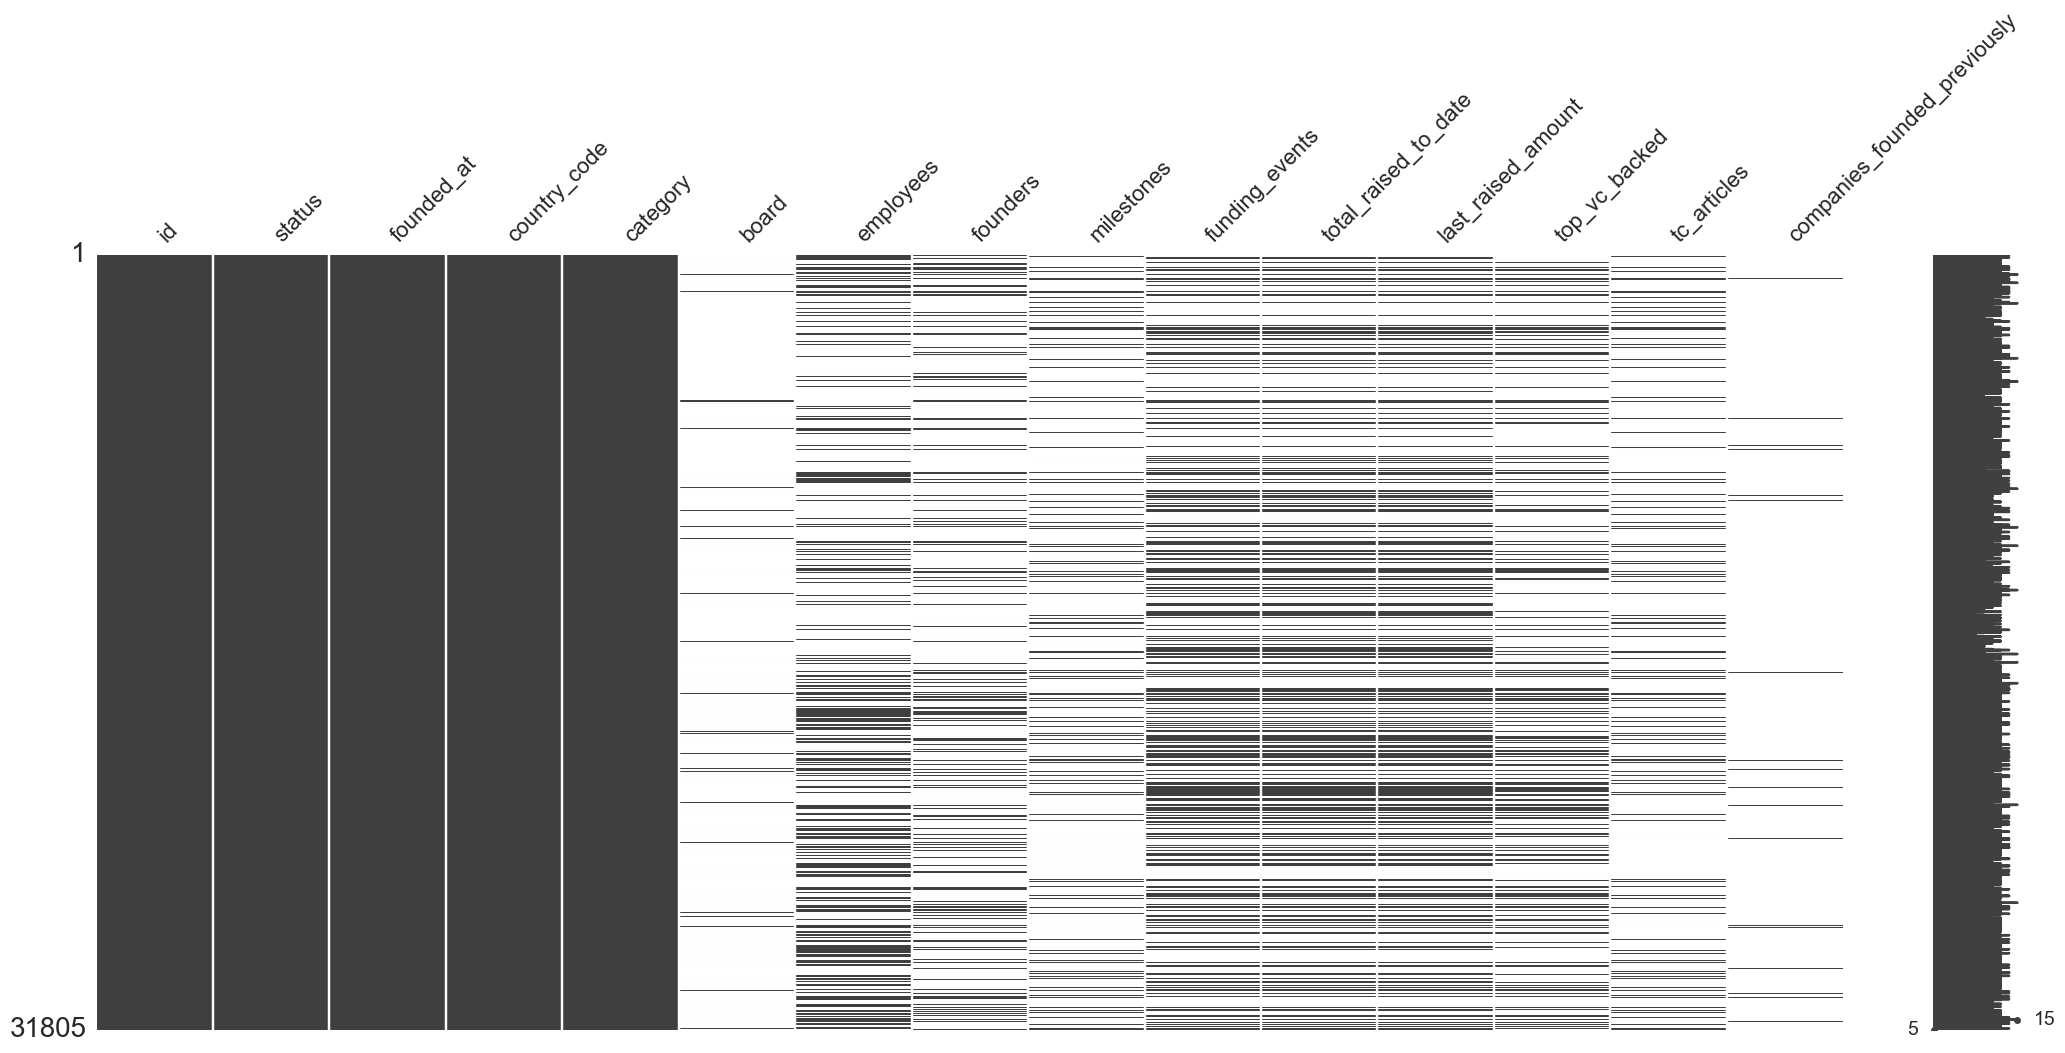

In [47]:
import missingno as msno
msno.matrix(all_data)

As you can see, some columns are better populated than others.  

In some cases its obvious why a column has a lot of missing values, e.g. board has a lot of missing data because most companies probably didn't have any board members when they were 3 years old.  

In other cases, its not so clear e.g. companies founded previously, I would have assumed there would be more experienced entrepreneurs out there. 

There are several ways one could go about filling in the missing data although not all are practical. Before we do go about filling in the missing data though, it's best to do some exploratory data analysis to get a better understanding of the data and understand whether data is missing at random or not. 

# EDA

First, let's see how many startups we have in each category. 

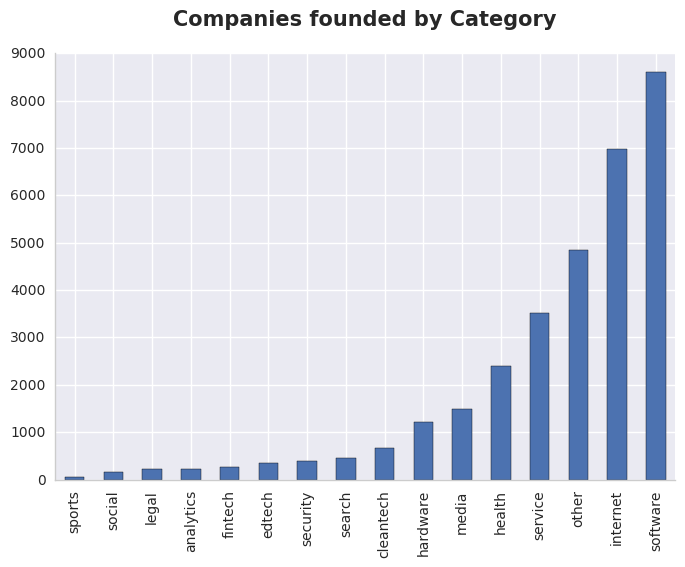

In [48]:
temp = all_data.copy()

ax = temp.groupby('category').size().sort_values().plot(kind="bar")

ax.legend().set_visible(False)

ax.tick_params(axis=u'both', which=u'both',length=0)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)

ax.set_title("Companies founded by Category", fontweight = 'bold', fontsize = 15, position = [.5,1.05])
ax.set_ylabel("", fontsize = 12, fontstyle = 'italic')
ax.set_xlabel("", fontsize = 12, fontstyle = 'italic')

First, let's see how many exits of each type we have exactly. 

In [49]:
temp = all_data.copy()

temp = temp.groupby(by = [temp.status]).id.nunique().reset_index()
temp.rename(columns={'id': 'Amount'}, inplace=True)

temp.head()

,status,Amount
0,acquired,3460
1,closed,894
2,ipo,551
3,operating,26900


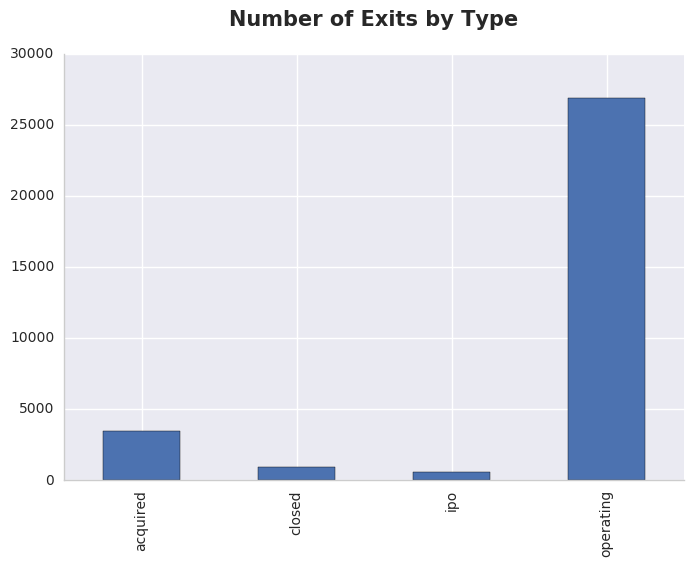

In [50]:
ax = temp.plot(x = 'status', y = 'Amount', kind="bar")

ax.legend().set_visible(False)

ax.tick_params(axis=u'both', which=u'both',length=0)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)

ax.set_title("Number of Exits by Type", fontweight = 'bold', fontsize = 15, position = [.5,1.05])
ax.set_ylabel("", fontsize = 12, fontstyle = 'italic')
ax.set_xlabel("", fontsize = 12, fontstyle = 'italic')

Number of positive exits per industry

In [51]:
temp = all_data.copy()

temp['exit'] = np.where(temp.status.isin(['acquired', 'ipo']), 'positive', 'negative')
temp = temp[temp.exit=='positive']

temp = temp.groupby(['category']).id.nunique().reset_index()
temp.rename(columns={'id': 'Amount'}, inplace=True)

temp['Prcnt'] = temp['Amount']/temp['Amount'].sum()*100
temp = temp.sort_values(by = 'Prcnt')

temp.head()

,category,Amount,Prcnt
7,legal,1,0.024931
15,sports,3,0.074794
2,edtech,12,0.299177
0,analytics,16,0.398903
13,social,23,0.573423


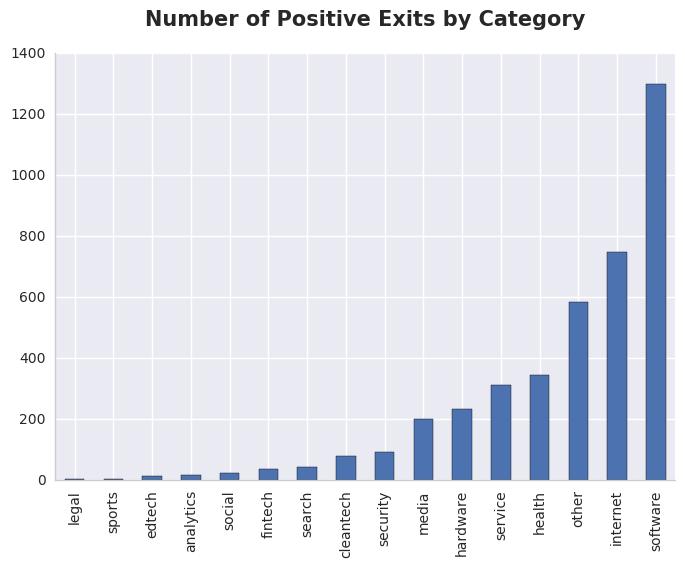

In [52]:
ax = temp.plot(x = 'category', y = 'Amount', rot = 90, kind = 'bar')

ax.legend().set_visible(False)

ax.tick_params(axis=u'both', which=u'both',length=0)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)

ax.set_title("Number of Positive Exits by Category", fontweight = 'bold', fontsize = 15, position = [.5,1.05])
ax.set_ylabel("", fontsize = 12, fontstyle = 'italic')
ax.set_xlabel("", fontsize = 12, fontstyle = 'italic')

Percentage of exits by industry

In [53]:
temp = all_data.copy()

temp['exit'] = np.where(temp.status.isin(['acquired', 'ipo']), 'positive', 'negative')

temp = temp.groupby(['category', 'exit']).id.nunique()
temp = temp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()
temp.rename(columns={'id': 'prcnt'}, inplace=True)

temp = temp.pivot_table(index='category', columns='exit', values='prcnt').reset_index()
temp = temp.sort_values(by = 'negative')
temp = temp.set_index('category')

temp.head()

exit,negative,positive
category,,
security,76.701571,23.298429
hardware,80.979592,19.020408
social,84.563758,15.436242
software,84.886562,15.113438
health,85.630744,14.369256


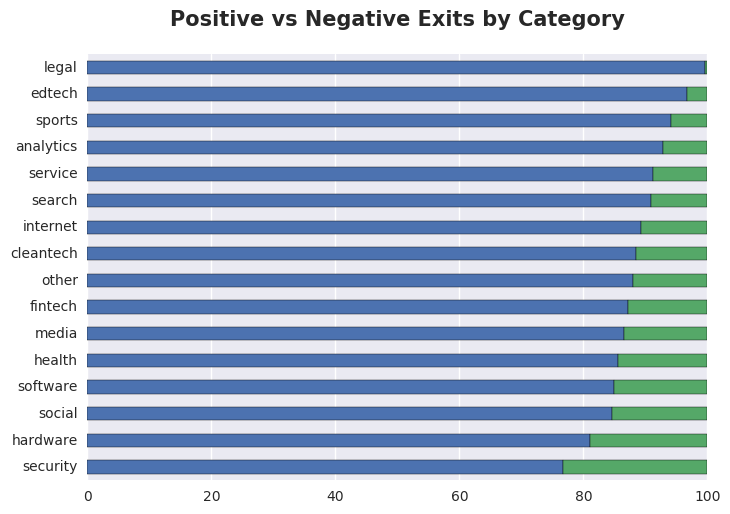

In [54]:
ax = temp.plot.barh(stacked=True)

ax.legend().set_visible(False)

ax.set_title("Positive vs Negative Exits by Category", fontweight = 'bold', fontsize = 15, position = [.5,1.05])
ax.set_ylabel("", fontsize = 12, fontstyle = 'italic')
ax.set_xlabel("", fontsize = 12, fontstyle = 'italic')

Next lets look at the average time to acquisition by sector. 

In [55]:
temp_ipos = cb_ipos.copy()
temp_ipos = temp_ipos[['object_id', 'public_at']]
temp_ipos['public_at'] = pd.to_datetime(temp_ipos.public_at)
temp_ipos.head()

temp_acquisitions = cb_acquisitions.copy()
temp_acquisitions = temp_acquisitions[['acquired_object_id', 'acquired_at']]
temp_acquisitions['acquired_at'] = pd.to_datetime(temp_acquisitions.acquired_at)
temp_acquisitions.head()

temp = all_data.copy()
temp = temp[['id', 'category', 'founded_at', 'status']]
temp = temp[(temp.status =='acquired') | (temp.status =='ipo')]

temp = pd.merge(temp, temp_ipos, how='left', left_on = 'id', right_on = 'object_id')
temp.drop('object_id', axis=1, inplace=True)

temp = pd.merge(temp, temp_acquisitions, how='left', left_on = 'id', right_on = 'acquired_object_id')
temp.drop('acquired_object_id', axis=1, inplace=True)

temp['exit_at'] = np.where(temp.status=='acquired', temp.acquired_at, temp.public_at)

temp = temp[['id', 'category', 'status', 'founded_at', 'exit_at']]

temp['time_to_exit'] = (temp['exit_at'] - temp['founded_at']).astype('timedelta64[M]')
temp = temp[temp.exit_at.notnull()]
temp = temp[temp.time_to_exit>0] # remove stupid values

temp = temp.groupby(by = ['category']).time_to_exit.mean().reset_index()
temp = temp.sort_values(by = 'time_to_exit')

temp.head()

,category,time_to_exit
7,legal,48.000000
13,social,78.136364
0,analytics,96.400000
6,internet,97.064085
8,media,99.881443


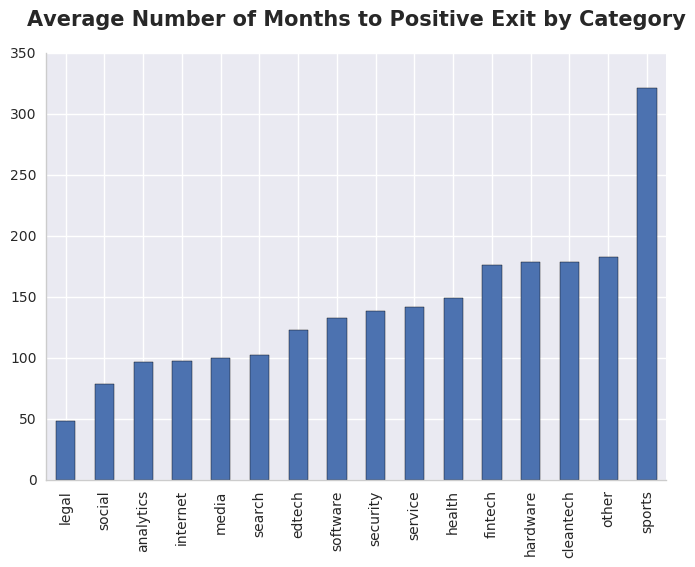

In [56]:
ax = temp.plot(x = 'category', y = 'time_to_exit', rot = 90, kind = 'bar')

ax.legend().set_visible(False)

ax.tick_params(axis=u'both', which=u'both',length=0)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)

ax.set_title("Average Number of Months to Positive Exit by Category", fontweight = 'bold', fontsize = 15, position = [.5,1.05])
ax.set_ylabel("", fontsize = 12, fontstyle = 'italic')
ax.set_xlabel("", fontsize = 12, fontstyle = 'italic')

Statistics of numerical features for companies in all categories

In [57]:
temp = all_data.copy()
temp = temp[['status', 'founded_at', 'board', 'employees', 'founders', 'milestones', 'funding_events', 'total_raised_to_date', 'last_raised_amount', 'top_vc_backed', 'tc_articles', 'companies_founded_previously']]

temp['exit'] = np.where(temp.status.isin(['acquired', 'ipo']), 'positive', 'negative')
temp.head()

,status,founded_at,board,employees,founders,milestones,funding_events,total_raised_to_date,last_raised_amount,top_vc_backed,tc_articles,companies_founded_previously,exit
0,operating,2005-10-17,1.0,NaN,2.0,0.0,3.0,39750000.0,25000000.0,2.0,0.0,NaN,negative
1,operating,2008-08-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,negative
2,operating,2008-08-01,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN,negative
3,acquired,2007-10-01,NaN,1.0,4.0,2.0,1.0,5000000.0,5000000.0,1.0,1.0,NaN,positive
4,operating,2008-01-01,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,negative


In [58]:
temp_positive = temp[temp.exit=='positive']
temp_positive = temp_positive.describe().transpose()
temp_positive = temp_positive[['mean', 'std', 'count']]

temp_positive.to_clipboard()
temp_positive

//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,mean,std,count
board,3.364055e-01,4.735719e-01,217.0
employees,3.528701e-01,4.780072e-01,1655.0
founders,1.686090e+00,8.735446e-01,1064.0
milestones,3.571429e-01,1.171221e+00,910.0
funding_events,8.127090e-01,1.063796e+00,1794.0
total_raised_to_date,6.533071e+06,3.461901e+07,1794.0
last_raised_amount,3.938735e+06,1.376595e+07,1794.0
top_vc_backed,1.897220e+00,6.352753e+00,1547.0
tc_articles,5.164835e-02,4.015544e-01,910.0
companies_founded_previously,7.625000e-01,9.482689e-01,160.0


In [59]:
temp_negative = temp[temp.exit=='negative']
temp_negative = temp_negative.describe().transpose()
temp_negative = temp_negative[['mean', 'std', 'count']]

temp_negative.to_clipboard()
temp_negative

//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,mean,std,count
board,2.143600e-01,4.105913e-01,961.0
employees,3.501985e-01,4.770590e-01,8815.0
founders,1.530182e+00,7.672083e-01,5268.0
milestones,5.321308e-01,1.491574e+00,3548.0
funding_events,5.605874e-01,8.495027e-01,9738.0
total_raised_to_date,2.768522e+06,1.786373e+07,9738.0
last_raised_amount,1.980190e+06,8.014881e+06,9738.0
top_vc_backed,1.039297e+00,5.169181e+00,6540.0
tc_articles,2.762120e-02,2.520249e-01,3548.0
companies_founded_previously,6.606742e-01,8.325606e-01,445.0


Scatterplot matrix

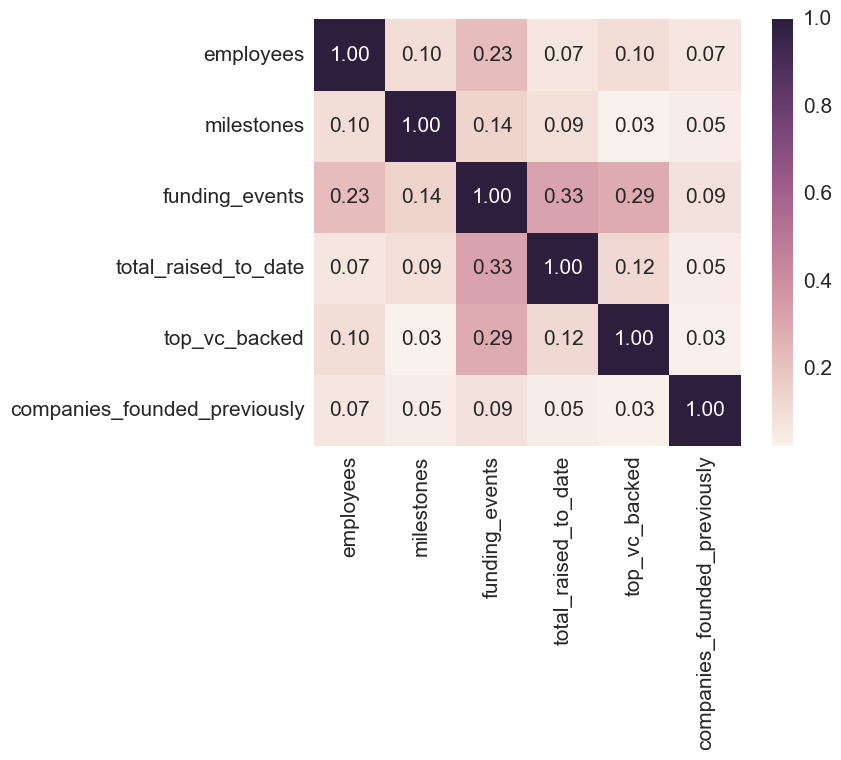

In [60]:
import seaborn as sns
sns.set(style='whitegrid', context='notebook')

temp = all_data.copy()
temp.board.fillna(inplace=True, value=0)
temp.employees.fillna(inplace=True, value=0)
temp.founders.fillna(inplace=True, value=1)
temp.milestones.fillna(inplace=True, value=0)
temp.funding_events.fillna(inplace=True, value=0)
temp.total_raised_to_date.fillna(inplace=True, value=0)
temp.last_raised_amount.fillna(inplace=True, value=0)
temp.top_vc_backed.fillna(inplace=True, value=0)
temp.tc_articles.fillna(inplace=True, value=0)
temp.companies_founded_previously.fillna(inplace=True, value=0)

cols = ['employees', 'milestones', 'funding_events', 'total_raised_to_date', 'top_vc_backed', 'companies_founded_previously']

cm = np.corrcoef(temp[cols].values.T)

sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols, xticklabels=cols)

plt.show()

# Machine Learning Preparation

The majority of machine learning algorithms I intend to apply require complete data (i.e. no missing data). 
Simply removing companies with incomplete data will leave us with less than 10,000 samples (the arbitrary rule) and also a biased sample since data is unlikely to be missing at random. 
We can however make some simplifying  assumptions for missing data in our features. 

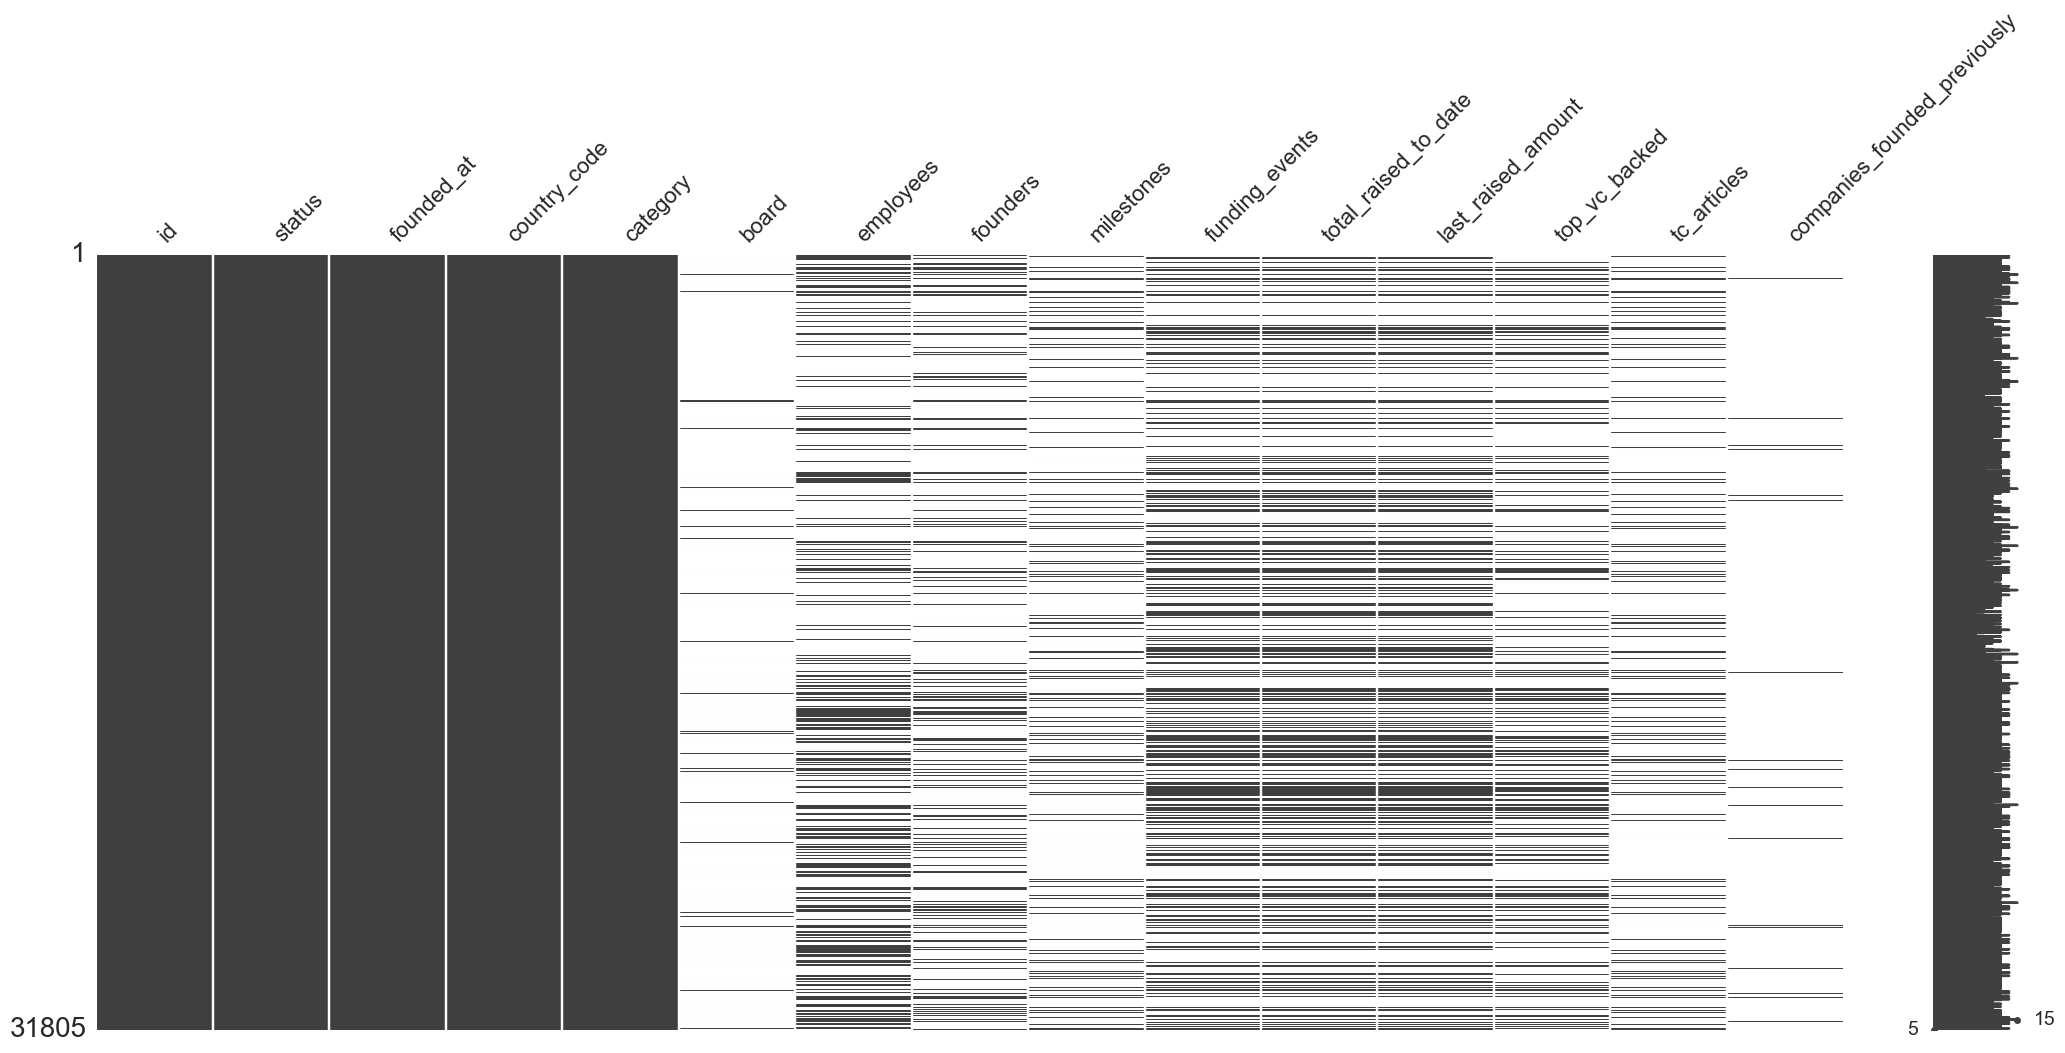

In [61]:
msno.matrix(all_data)

Since CrunchBase consists largely of self-reported data, the missing data phenomenon is not surprising. As is it is a fairly popular source for data on startups, similar to how LinkedIn is the first source of information people will turn to for information on professional contacts, I assume there is significant motivation for founders to fill in data where available and keep that data up to date. Therefore, any missing data should indicate the presence of a 0. For example, if a company did not report any funding, we will assume that this company raised $0. We can make similar assumptions for the other variables. 

In [62]:
all_data.board.fillna(inplace=True, value=0)
all_data.employees.fillna(inplace=True, value=0)
all_data.founders.fillna(inplace=True, value=0)
all_data.milestones.fillna(inplace=True, value=0)
all_data.funding_events.fillna(inplace=True, value=0)
all_data.total_raised_to_date.fillna(inplace=True, value=0)
all_data.last_raised_amount.fillna(inplace=True, value=0)
all_data.top_vc_backed.fillna(inplace=True, value=0)
all_data.tc_articles.fillna(inplace=True, value=0)
all_data.companies_founded_previously.fillna(inplace=True, value=0)

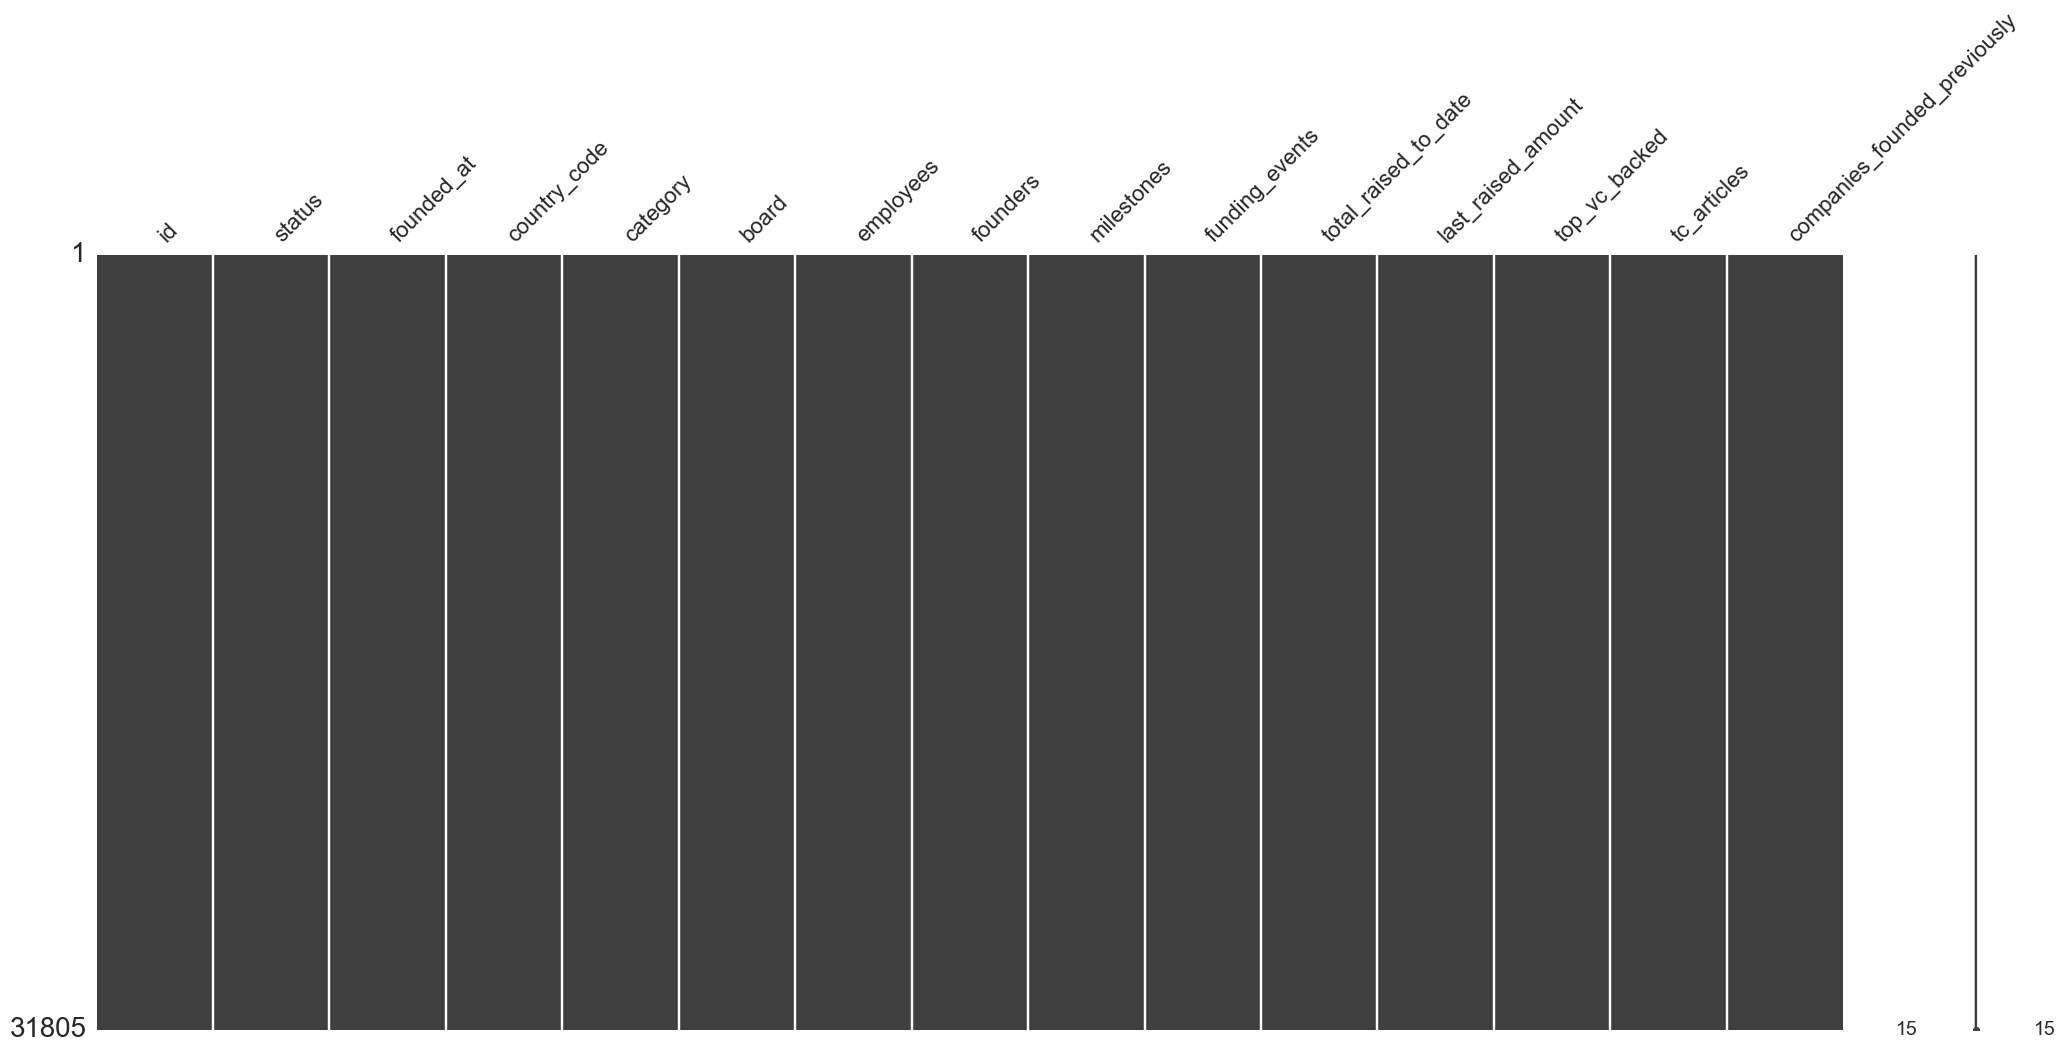

In [63]:
msno.matrix(all_data)

Next, let's dummify the cardinal categorical variables, (in our case just Category).

In [64]:
from sklearn.preprocessing import StandardScaler

all_data['founded_at'] = all_data.founded_at.dt.year

columns = ['country_code', 'category']

for column in columns: 
    dum = pd.get_dummies(all_data[column], prefix = column, dummy_na=True)
    all_data = pd.concat([all_data, dum], axis = 1)
    all_data = all_data.drop(column, axis = 1)

all_data.head()

,id,status,founded_at,board,employees,founders,milestones,funding_events,total_raised_to_date,last_raised_amount,top_vc_backed,tc_articles,companies_founded_previously,country_code_AUS,country_code_CAN,country_code_DEU,country_code_FRA,country_code_GBR,country_code_IND,country_code_USA,country_code_nan,category_analytics,category_cleantech,category_edtech,category_fintech,category_hardware,category_health,category_internet,category_legal,category_media,category_other,category_search,category_security,category_service,category_social,category_software,category_sports,category_nan
0,c:1,operating,2005,1.0,0.0,2.0,0.0,3.0,39750000.0,25000000.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,c:10003,operating,2008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,c:10009,operating,2008,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,c:1001,acquired,2007,0.0,1.0,4.0,2.0,1.0,5000000.0,5000000.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,c:10011,operating,2008,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, let's split the data into training and testing samples. 

In [65]:
all_data = all_data.drop('id', axis = 1)

all_data = all_data[all_data.status.isin(['operating', 'acquired', 'ipo'])]
len(all_data)

30911

Seperate our x and y variables.

In [66]:
x = all_data.drop('status', axis = 1).values

y = ((all_data.status == 'acquired') | (all_data.status == 'ipo')).values.astype(np.int)

Split our data ito training and testing sets. 

In [67]:
from sklearn.cross_validation import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3, random_state = 2)

print("Training X samples:", xtrain.shape[0])
print("Training Y samples:", ytrain.shape[0])
print()
print("Testing X samples:", xtest.shape[0])
print("Testing Y samples:", ytest.shape[0])

Training X samples: 21637
Training Y samples: 21637

Testing X samples: 9274
Testing Y samples: 9274


//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


For some models, we will need our features to be standardised.  

In [68]:
sc = StandardScaler()
xtrain_std = sc.fit_transform(xtrain)
xtest_std = sc.transform(xtest)

print("Training X standardised samples:", xtrain_std.shape[0])
print("Testing X standardised samples:", xtest_std.shape[0])

Training X standardised samples: 21637
Testing X standardised samples: 9274


There's also one more thing we need to do.  
Given the significant imbalance in our dataset, we should use some kind of sampling technqiue to create balanced samples for our training data.  
One popular method of sampling is SMOTE (Syntheic Minority Over-sampling Technique).  

As its name suggests, SMOTE is an oversampling method and  works by creating synthetic samples from the minor class instead of creating copies. The algorithm selects two or more similar instances (using a distance measure) and perturbing an instance one attribute at a time by a random amount within the difference to the neighboring instances.  

To learn more about SMOTE, see the original 2002 paper titled “SMOTE: Synthetic Minority Over-sampling Technique“.

In [69]:
from imblearn.over_sampling import SMOTE

# Apply regular SMOTE
sm = SMOTE(kind='regular')

xtrain_resampled, ytrain_resampled = sm.fit_sample(xtrain, ytrain)

# Standardised resampled data
xtrain_resampled_std = sc.fit_transform(xtrain_resampled)

Just to check everything is working fine with this resampling (as this is a critical step)...

In [70]:
print("Minority class: ", str(sm.min_c_))
print("Majority class: ", str(sm.maj_c_))
print("Occurrences of each class: ", str(sm.stats_c_))
print("")
print("Shape of original X: ", str(sm.X_shape_))
print("Shape of resampled X: ", str(xtrain_resampled.shape))

Minority class:  1
Majority class:  0
Occurrences of each class:  Counter({0: 18843, 1: 2794})

Shape of original X:  (21637, 36)
Shape of resampled X:  (37686, 36)


As you can see, resampled X has more observations than our original X. This is to be expected since we just applied oversampling to the original X i.e. increased the number of observations of the minority class in X. 

Now let's set up some custom functions for selecting the best combination of parameters through cross validation. 

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform_rand

#scorer = make_scorer(precision_score, pos_label=1)
#scorer = make_scorer(recall_score, pos_label=1)
scorer = make_scorer(f1_score, pos_label=1)

Create a function to easily plot a confusion matrix. 

In [72]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        cm = cm
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [73]:
from sklearn.metrics import confusion_matrix

def custom_confusion_matrix(clf, 
                            x_data = xtest, 
                            y_data = ytest):

    y_true = y_data
    y_pred = clf.predict(x_data)

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    TP = cm[1][1]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[0][0]

    Precision = TP / (TP + FP)
    Specificity = TN / (TN + FP)
    Recall = TP / (TP + FN)
    F1 = 2*((Precision*Recall)/(Precision+Recall))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=[0,1], title='Confusion matrix, without normalization')
    plt.show()

    print("TP = {}".format(TP))
    print("FP = {}".format(FP))
    print("TN = {}".format(TN))
    print("FN = {}".format(FN))
    print(" ")
    print('Precision ( or TPR) = {}'.format(round(Precision, 2)))
    print('Specificity ( or TNR) = {}'.format(round(Specificity, 2)))
    print('Recall = {}'.format(round(Recall, 2)))
    print('F1 = {}'.format(round(F1 , 2)))

A function to plot precision-recall curve. 

In [74]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve

def scorePrimitive(classifier, input, result):
    predictions = classifier.predict(input)
    (precision, recall, fscore, threshold) = precision_recall_fscore_support(result, predictions, average='micro')
    print('Precision: %0.2f ; Recall: %0.2f ; F-Score: %0.2f' % (precision, recall, fscore))
    num_true_positives = 0
    num_true_negatives = 0
    num_false_positives = 0
    num_false_negatives = 0
    
    for i, prediction in enumerate(predictions):
        if prediction == 0:
            if result[i] == 0:
                num_true_negatives += 1
            else:
                num_false_negatives += 1
        else:
            if result[i] == 1:
                num_true_positives += 1
            else:
                num_false_positives += 1
        
        print('Num True Positives: ', num_true_positives)
        print('Num False Positives: ', num_false_positives)
        print('Num True Negatives: ', num_true_negatives)
        print('Num False Negatives: ', num_false_negatives)


def score(classifier, input, result, title):
    #print('For %s' % title)
    predictions = classifier.predict_proba(input)
    precision, recall, thresholds = precision_recall_curve(result, predictions[:, 1])
    area = auc(recall, precision)
    #print("Area Under Curve for %s: %0.2f" % (title, area))
    
    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('%s AUC=%0.2f' % (title, area))
    plt.legend(loc="upper right")
    plt.show()
    #scorePrimitive(classifier, input, result)

A function to plot an ROC (TPR vs TNR) curve. 

In [75]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

def custom_roc(clf, x, y):
    
    classifier = clf

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    lw = 2
 
    probas_ = classifier.predict_proba(x)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y, probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color='blue',
             label='ROC (area = %0.2f)' % roc_auc)
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

That's it. We're done! 
Now for some machine learning.

# Naive Bayes

A gaussian naive bayes model won't work here as most of our features exhibit a strong skew to the right.  
A multinomial naive bayes model is likely to work better for this classification task.  
First, we need to pick our choice of alpha for laplace smoothing. 

In [76]:
from sklearn.naive_bayes import MultinomialNB

# prepare a range of alpha values to test
parameters = np.array([.1, 1, 5, 10, 50, 100, 1000])

# create and fit a MNB model, testing each alpha
grid = GridSearchCV(estimator = MultinomialNB(), 
                    param_grid = dict(alpha = parameters), 
                    cv = 5,
                    scoring = scorer)

grid = grid.fit(xtrain, ytrain)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

0.0822912338703
0.1


In [77]:
mnb = MultinomialNB(alpha = grid.best_estimator_.alpha)
mnb.fit(xtrain, ytrain)

MultinomialNB(alpha=0.10000000000000001, class_prior=None, fit_prior=True)

Excellent, now let's see our overall accuracy rate. 

In [78]:
print ("MN Overall Accuracy: %0.2f%%" % (100 * mnb.score(xtest, ytest)))

MN Overall Accuracy: 85.76%


We're seeing what's look like a very impressive overall accuracy rate with our model!  

Unfortunately, this would be falling prey to what is known as the accuracy paradox.  
It is the case where your accuracy measures tell the story that you have excellent accuracy (like we're seeing), but the accuracy is only reflecting the underlying class distribution.  More specifically, the reason we get such a high accuracy rate overall on an imbalanced dataset like ours is because our model looks at the data and cleverly decides that the best thing to do is to always predict “Class 0” and thus achieve high accuracy.  

Instead, what we should really be looking at are the true postive, false positive, true negative and false negative rates. A confusion matrix is a really helpful way for breaking down predictions into a table showing correct predictions (the diagonal) and the types of incorrect predictions made (what classes incorrect predictions were assigned to). Let's try to make one below. 

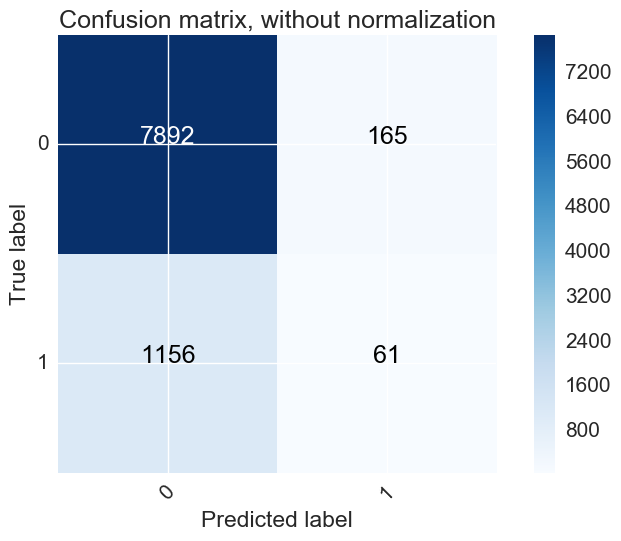

TP = 61
FP = 165
TN = 7892
FN = 1156
 
Precision ( or TPR) = 0.27
Specificity ( or TNR) = 0.98
Recall = 0.05
F1 = 0.08


In [79]:
custom_confusion_matrix(clf = mnb, x_data = xtest, y_data = ytest)

So now, we're starting to get a clearer picture of the performance of our model and its not looking good.  

While the model does a fairly good job of predicting 0s (non-acquired/non-ipo companies), we do a very poor job of predicting 1s (acquired/ipo companies) and this is what we really care about. We only get those right about 19% of the time. 

19% doesn't sound great obviously on its own but it would be interesting to see how this figure compares to traditional VC success rates. 

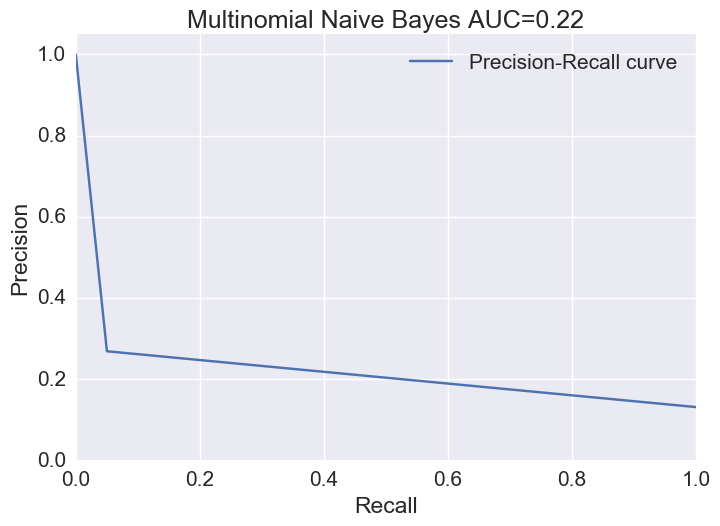

In [80]:
score(mnb, xtest, ytest, 'Multinomial Naive Bayes')

A high area under the curve would represent both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall). 

In our case, you can see the precision and recall are both pretty poor across the range of threshold values. 

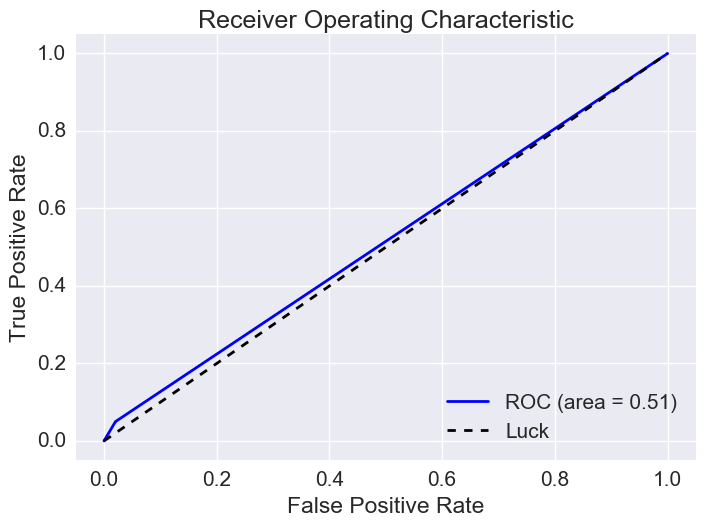

In [81]:
custom_roc(clf = mnb, x = xtest, y = ytest)

In fact, this entire model is pretty much garbage.  

# Naive Bayes with resampled data

Let's try again with resampled data.  
This will make sure our classes are more balanced.  

In addition, we're also only going to use a subset of the features.  
This is because it is known that performance of Naive Bayes models suffer in domains that involve correlated features.  
See Chotirat “Ann” Ratanamahatana Dimitrios Gunopulos at http://alumni.cs.ucr.edu/~ratana/DCAP02.pdf  
*Naïve Bayes can suffer from oversensitivity to redundant and/or irrelevant attributes. If two or more attributes are highly correlated, they receive too much weight in the final decision as to which class an example belongs to. This leads to a decline in accuracy of prediction in domains with correlated features.*

In [82]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

rf = RandomForestClassifier()
rf.fit(xtrain_resampled, ytrain_resampled)

selections = rf.feature_importances_ > 0.05

temp_xtrain = xtrain_resampled[:, selections]
temp_xtest = xtest[:, selections]

print(rf.feature_importances_)
print(np.sum(selections))

[ 0.38398627  0.0055893   0.05449433  0.08442344  0.0178782   0.0333875
  0.02895213  0.02630651  0.0304475   0.00283531  0.0056053   0.00464826
  0.01160264  0.00841202  0.00554989  0.01417372  0.02678595  0.08485626
  0.          0.00402825  0.00725578  0.00741709  0.00360463  0.01011341
  0.01131808  0.02855416  0.00684034  0.01027897  0.01945872  0.00492223
  0.0054914   0.01542408  0.00272622  0.03167697  0.00095516  0.        ]
4


In [83]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha = grid.best_estimator_.alpha)
mnb.fit(temp_xtrain, ytrain_resampled)

MultinomialNB(alpha=0.10000000000000001, class_prior=None, fit_prior=True)

In [84]:
from sklearn.naive_bayes import MultinomialNB

# prepare a range of alpha values to test
parameters = np.array([.1, 1, 5, 10, 50, 100, 1000])

# create and fit a MNB model, testing each alpha
grid = GridSearchCV(estimator = MultinomialNB(), 
                    param_grid = dict(alpha = parameters), 
                    cv = 5,
                    scoring = scorer)

grid = grid.fit(temp_xtrain, ytrain_resampled)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

0.414572588894
0.1


In [85]:
mnb = MultinomialNB(alpha = grid.best_estimator_.alpha)
mnb.fit(temp_xtrain, ytrain_resampled)

MultinomialNB(alpha=0.10000000000000001, class_prior=None, fit_prior=True)

In [86]:
print ("MN Overall Accuracy: %0.2f%%" % (100 * mnb.score(temp_xtest, ytest)))

MN Overall Accuracy: 70.52%


We get worse overall performance on this model but as we've said before, this does not tell the whole story.  

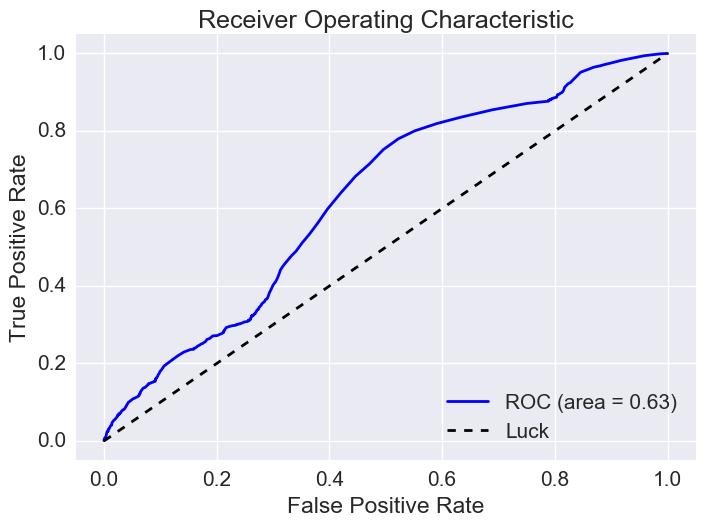

In [87]:
custom_roc(clf = mnb, x = temp_xtest, y = ytest)

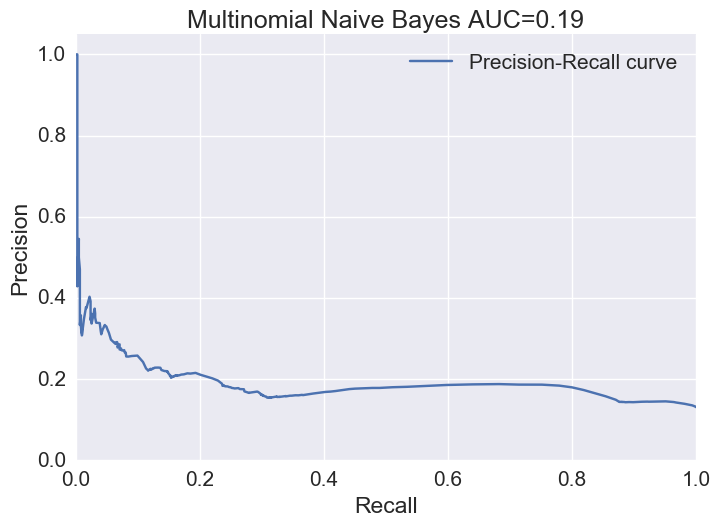

In [88]:
score(mnb, temp_xtest, ytest, 'Multinomial Naive Bayes')

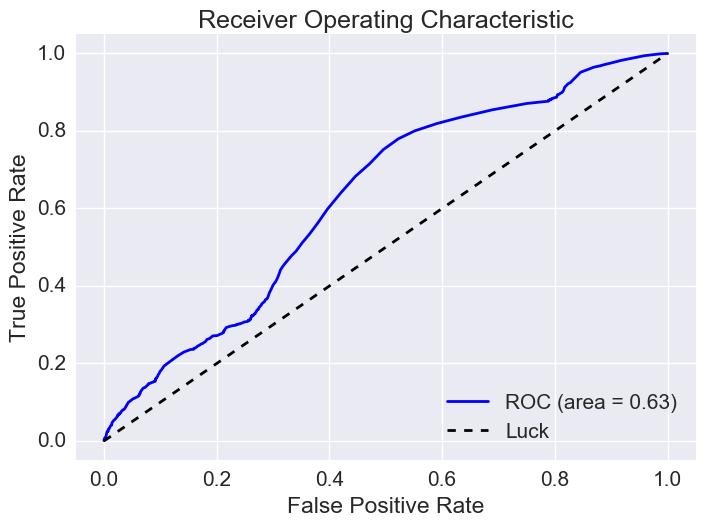

In [89]:
custom_roc(clf = mnb, x = temp_xtest, y = ytest)

We get slightly better performance with this improved model.  
Let's see if we can do better with any advanced models.  

# K Nearest Neighbours with resampled data

K Nearest Neighbours (more commonly referred to as kNN) is an algorithm starts off with a training dataset made up of examples that are classified into several categories. For each record in the test dataset, kNN identifies k records in the training data that are the "nearest" in similarity. This unlabeled test record is then assigned to the class of the majority of the k nearest neighbors. 

Its an extremely simple and sometimes effective algorithm. In addition, unlike multinomial naive bayes it makes absolutely no assumptions about the underlying data distribution. On the downside, it doesn't produce a model, the classification stage is slow and it requires a large amount of memory (depending on the size of the training data).  

So let's try KNN, again using resampled data.  
We will also extract the first 10 principal components as KNN is known to be sensitive to high dimensionality data.  

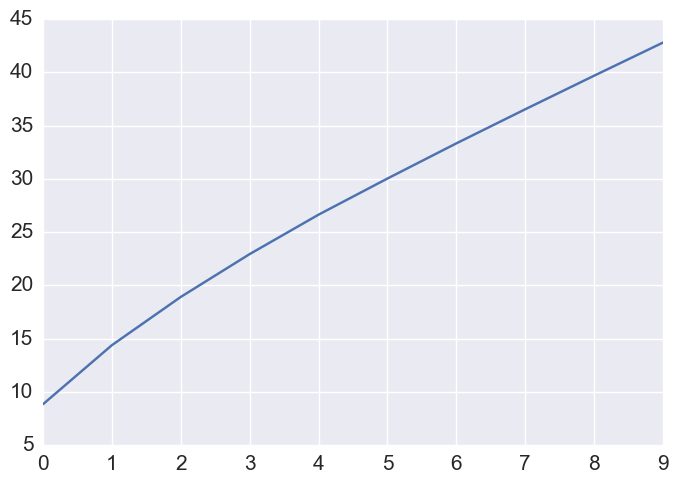

In [90]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)

pca.fit(xtrain_resampled_std)

xtrain_pca = pca.transform(xtrain_resampled_std)
xtest_pca = pca.transform(xtest_std)

# The amount of variance that each PC explains
var = pca.explained_variance_ratio_

# Cumulative Variance explained
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

#print(var1)
plt.plot(var1)

Looking at the above plot, we see that we only need the first 10 principal components to explain 40% of the variance. 


In [91]:
from sklearn.neighbors import KNeighborsClassifier

# prepare a range of parameter values to test
parameters = {'n_neighbors' : sp_randint(1, 20),
              'weights': ['uniform', 'distance'],
              'metric': ['minkowski', 'euclidean'], 
              'algorithm': ['ball_tree', 'kd_tree']}

# create and fit a decision tree, testing each parameter with random samples
grid = RandomizedSearchCV(estimator = KNeighborsClassifier(n_jobs=2), 
                          param_distributions = parameters,
                          cv = 5,
                          n_iter = 200)

grid = grid.fit(xtrain_pca, ytrain_resampled)

# summarize the results of the grid search
print('Best score', str(round(grid.best_score_))) #0.25
print(grid.best_params_)

KeyboardInterrupt: 

Fit model. 

In [92]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(**grid.best_params_, 
                           n_jobs = 2)

knn.fit(xtrain_pca, ytrain_resampled)

NotFittedError: This RandomizedSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [ ]:
y_true = ytest
y_pred = knn.predict(xtest_pca)

# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

TP = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[0][0]

Precision = TP / (TP + FP)
Specificity = TN / (TN + FP)
Recall = TP / (TP + FN)
F1 = 2*((Precision*Recall)/(Precision+Recall))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=[0,1], title='Confusion matrix, without normalization')
plt.show()

print("TP = {}".format(TP))
print("FP = {}".format(FP))
print("TN = {}".format(TN))
print("FN = {}".format(FN))
print(" ")
print('Precision (TPR) = {}'.format(round(Precision, 2)))
print('Specificity (TNR) = {}'.format(round(Specificity, 2)))
print('Recall = {}'.format(round(Recall, 2)))
print('F1 = {}'.format(round(F1 , 2)))

In [ ]:
#score(knn, temp_xtest, ytest, 'k Nearest Neighbours')
#knn does not have a predict_proba method, obviously

In [ ]:
custom_roc(clf = knn, x = xtest_pca, y = ytest)

In [ ]:
from sklearn.pipeline import Pipeline
knn = Pipeline([('pca', PCA(n_components = 10)), 
                ('knn', KNeighborsClassifier(**grid.best_params_, n_jobs=2))])
knn

This model is complete garbage.  

# SVM

Let's try an SVM now. 

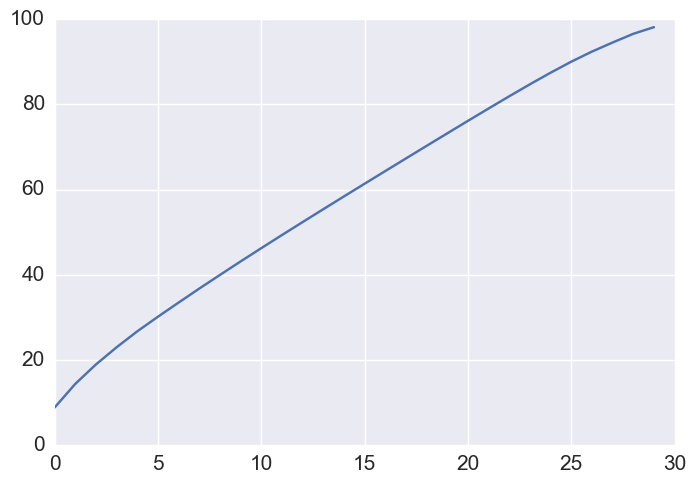

In [93]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 30)

pca.fit(xtrain_resampled_std)

xtrain_resampled_pca = pca.transform(xtrain_resampled_std)
xtest_pca = pca.transform(xtest_std)

# The amount of variance that each PC explains
var = pca.explained_variance_ratio_

# Cumulative Variance explained
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

#print(var1)
plt.plot(var1)

In [94]:
from sklearn.linear_model import SGDClassifier

# prepare a range of parameter values to test
parameters = {'loss': ['log', 'modified_huber', 'squared_hinge', 'perceptron'],
              'penalty': ['none', 'l2', 'l1', 'elasticnet'], 
              'learning_rate': ['constant', 'optimal', 'invscaling'],
              'class_weight': ['balanced', None], 
              'eta0': sp_uniform_rand(0, 1)}

# create and fit a decision tree, testing each parameter with random samples
grid = RandomizedSearchCV(estimator = SGDClassifier(n_jobs=2), 
                          param_distributions = parameters,
                          cv = 5,
                          n_iter = 10) #200

grid = grid.fit(xtrain_resampled_pca, ytrain_resampled)

# summarize the results of the grid search
print('Best score', str(round(grid.best_score_, 2)))
print(grid.best_params_)

Best score 0.64
{'loss': 'log', 'class_weight': None, 'penalty': 'l2', 'eta0': 0.14173282007034427, 'learning_rate': 'invscaling'}


Time to actually fit a model with our best parameters. 

In [95]:
from sklearn.linear_model import SGDClassifier

svm = SGDClassifier(**grid.best_params_)
svm.fit(xtrain_resampled_pca, ytrain_resampled)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.14173282007034427, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

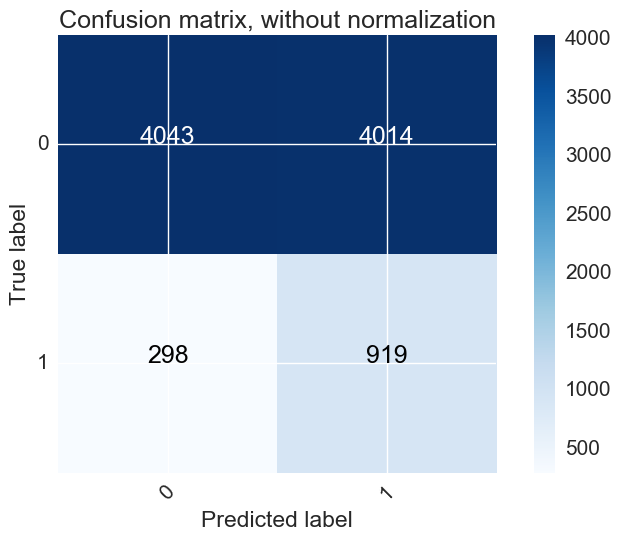

TP = 919
FP = 4014
TN = 4043
FN = 298
 
Precision ( or TPR) = 0.19
Specificity ( or TNR) = 0.5
Recall = 0.76
F1 = 0.3


In [96]:
custom_confusion_matrix(clf = svm, x_data = xtest_pca, y_data = ytest)

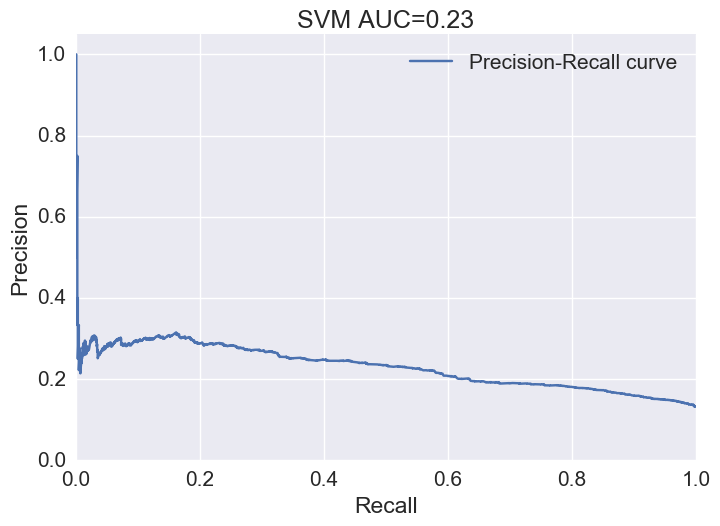

In [97]:
score(svm, xtest_pca, ytest, 'SVM')

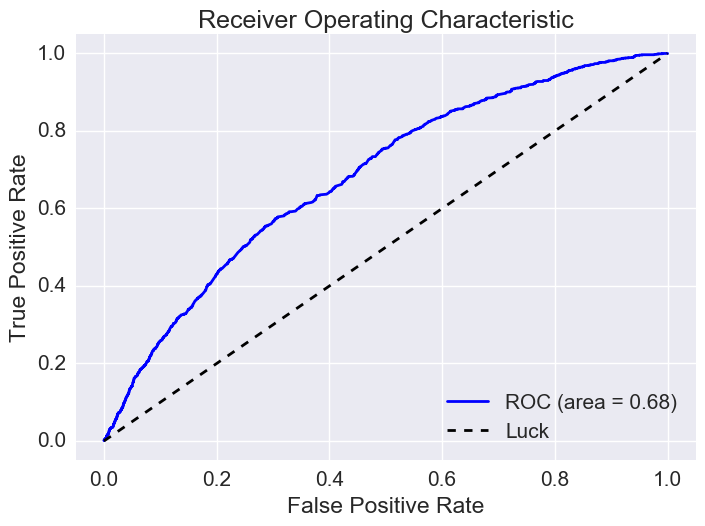

In [98]:
custom_roc(clf = svm, x = xtest_pca, y = ytest)

This seems like an acceptable model.  
Lets create a pipeline which we'll use later on to create an ensemble voting classifier model. 

In [99]:
from sklearn.pipeline import Pipeline
svm = Pipeline([('pca', PCA(n_components = 30)), 
                ('svm', SGDClassifier(**grid.best_params_))])
svm

Pipeline(steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('svm', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.14173282007034427, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False))])

# Decision Tree with resampled data

Tune parameters. 

In [100]:
from sklearn.tree import DecisionTreeClassifier

parameters = {'criterion': ['gini', 'entropy'], 
              'splitter': ['best', 'random'],
              'max_features': sp_uniform_rand(0, 1),
              'max_depth': sp_randint(2, 200), 
              'min_samples_split': sp_randint(2, 1000),
              'min_samples_leaf': sp_randint(2, 1000),
              'min_weight_fraction_leaf': sp_uniform_rand(0, 0.5), 
              'class_weight': ['balanced', None]
             }

# create and fit a decision tree, testing each parameter with random samples
grid = RandomizedSearchCV(estimator = DecisionTreeClassifier(random_state=0), 
                          param_distributions = parameters,
                          cv = 5,
                          n_iter = 200)

grid = grid.fit(xtrain_resampled, ytrain_resampled)

# summarize the results of the grid search
print('Best score', str(round(grid.best_score_, 2)))
print(grid.best_params_)

Best score 0.71
{'class_weight': None, 'min_samples_leaf': 15, 'min_samples_split': 844, 'max_depth': 197, 'max_features': 0.470755200073251, 'splitter': 'best', 'criterion': 'entropy', 'min_weight_fraction_leaf': 0.0035488332005566003}


Fit classifier. 

In [101]:
tree = DecisionTreeClassifier(#**grid.best_params_,
                              class_weight = None, 
                              min_samples_leaf = 15, 
                              min_samples_split = 844, 
                              max_depth = 197, 
                              max_features = 0.470755200073251, 
                              splitter = 'best', 
                              criterion = 'entropy', 
                              min_weight_fraction_leaf = 0.0035488332005566003,
                              random_state = 0)

tree.fit(xtrain_resampled, ytrain_resampled)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=197,
            max_features=0.470755200073251, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=15,
            min_samples_split=844,
            min_weight_fraction_leaf=0.0035488332005566003, presort=False,
            random_state=0, splitter='best')

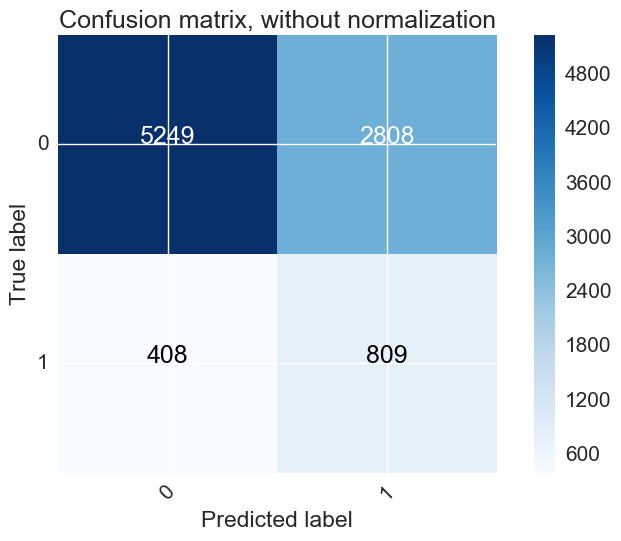

TP = 809
FP = 2808
TN = 5249
FN = 408
 
Precision ( or TPR) = 0.22
Specificity ( or TNR) = 0.65
Recall = 0.66
F1 = 0.33


In [103]:
custom_confusion_matrix(clf = tree, x_data = xtest, y_data = ytest)

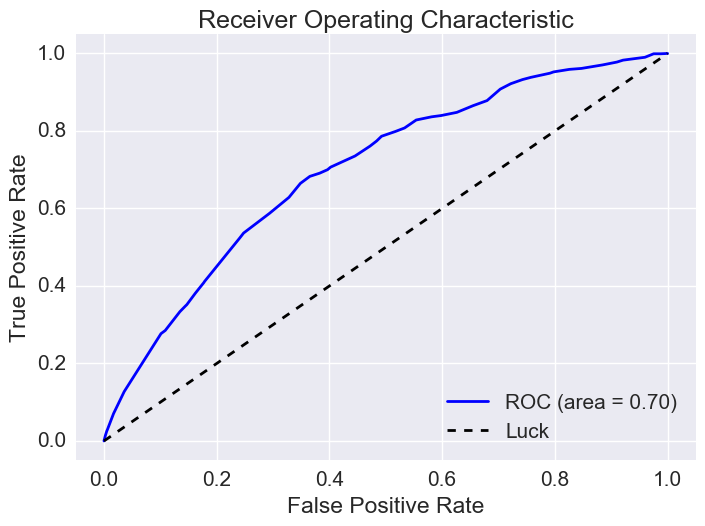

In [105]:
custom_roc(clf = tree, x = xtest, y = ytest)

# Random Forests with resampled data

Time to tune our parameters. 

In [106]:
from sklearn.ensemble import RandomForestClassifier

# prepare a range of parameter values to test
parameters = {'n_estimators' : [10, 100, 500], 
              'criterion': ['gini', 'entropy'], 
              'max_features': sp_uniform_rand(0, 1),
              'max_depth': sp_randint(2, 200), 
              'min_samples_split': sp_randint(2, 1000),
              'min_samples_leaf': sp_randint(2, 1000),
              'min_weight_fraction_leaf': sp_uniform_rand(0, 0.5), 
              'class_weight': ['balanced', 'balanced_subsample', None]
             }

# create and fit a decision tree, testing each parameter with random samples
grid = RandomizedSearchCV(estimator = RandomForestClassifier(random_state = 0, n_jobs = 2), 
                          param_distributions = parameters,
                          cv = 5,
                          n_iter = 200)

grid = grid.fit(xtrain_resampled, ytrain_resampled)

# summarize the results of the grid search
print('Best score', str(round(grid.best_score_, 2))) #0.25
print(grid.best_params_)

Best score 0.72
{'class_weight': 'balanced', 'min_samples_leaf': 95, 'min_samples_split': 337, 'max_depth': 171, 'max_features': 0.89878843971842626, 'n_estimators': 100, 'criterion': 'entropy', 'min_weight_fraction_leaf': 0.0076717996317994808}


In [108]:
forest = RandomForestClassifier(#**grid.best_params_
                                class_weight = 'balanced', 
                                min_samples_leaf = 95, 
                                min_samples_split = 337, 
                                max_depth = 171, 
                                max_features = 0.89878843971842626, 
                                n_estimators = 100, 
                                criterion = 'entropy',
                                min_weight_fraction_leaf = 0.0076717996317994808,
                                n_jobs = 2)

forest.fit(xtrain_resampled, ytrain_resampled)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=171,
            max_features=0.89878843971842626, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=95,
            min_samples_split=337,
            min_weight_fraction_leaf=0.0076717996317994808,
            n_estimators=100, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

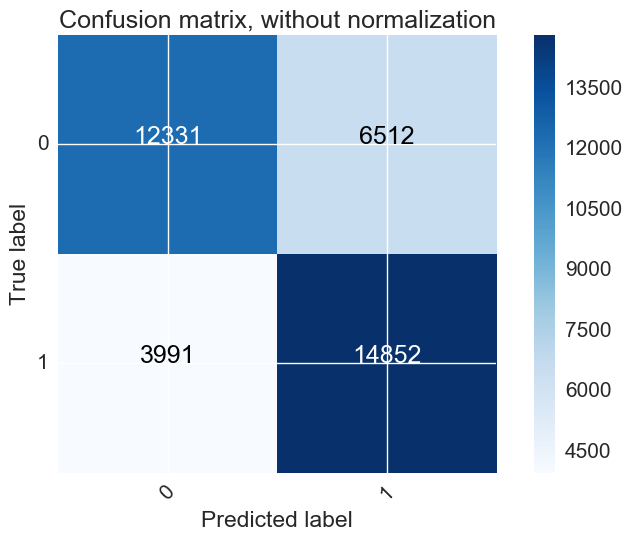

TP = 14852
FP = 6512
TN = 12331
FN = 3991
 
Precision ( or TPR) = 0.7
Specificity ( or TNR) = 0.65
Recall = 0.79
F1 = 0.74


In [110]:
custom_confusion_matrix(clf = forest, x_data = xtrain_resampled, y_data = ytrain_resampled)

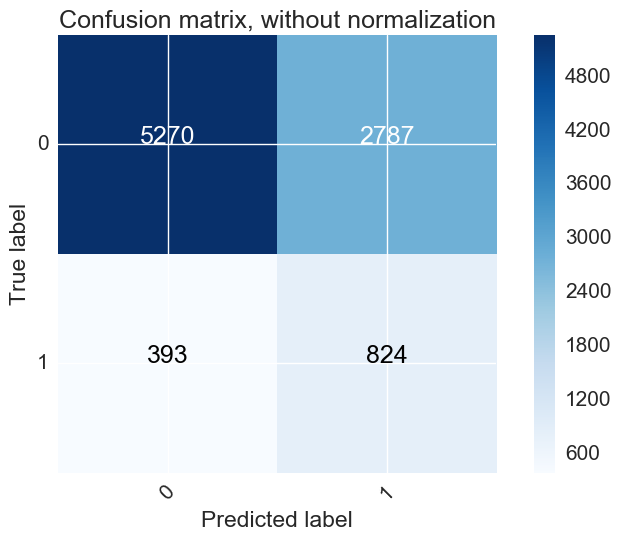

TP = 824
FP = 2787
TN = 5270
FN = 393
 
Precision ( or TPR) = 0.23
Specificity ( or TNR) = 0.65
Recall = 0.68
F1 = 0.34


In [112]:
custom_confusion_matrix(clf = forest, x_data = xtest, y_data = ytest)

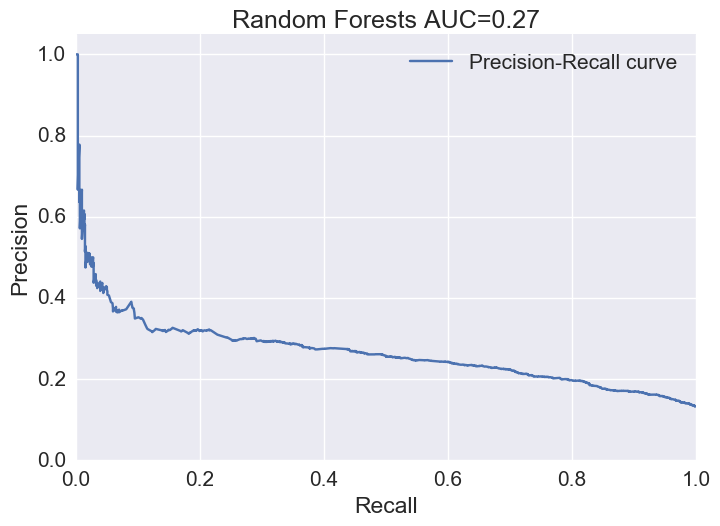

In [114]:
score(forest, xtest, ytest, 'Random Forests')

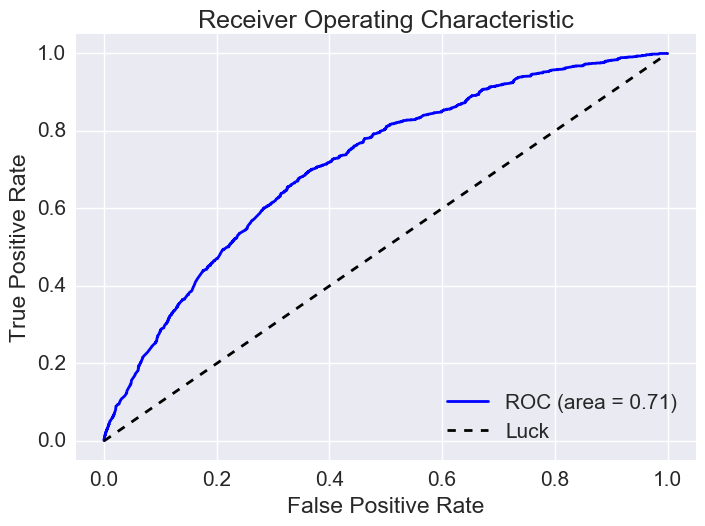

In [115]:
custom_roc(clf = forest, x = xtest, y = ytest)

Another valuble piece of information we can get from Random Forests models is feature importance.  

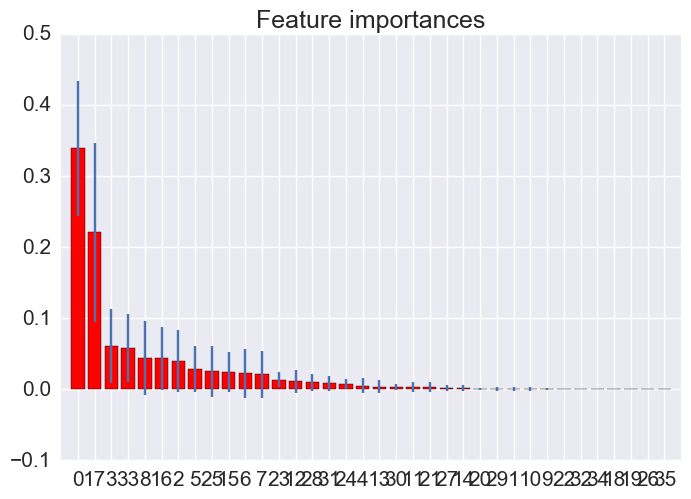

In [116]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")
#for f in range(x.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), indices)
plt.xlim([-1, x.shape[1]])
plt.show()

# Gradient Boosted trees

While Random Forests was a bagging method, Gradient Boosted trees are a boosting method. 

Boosting is an ensembling technique, i.e. a prediction is made by an ensemble of simpler estimators, usually decision trees. 

When you add more decision trees to a random forest, they decide what they think **independantly** of all the other trees. This is to say that they learn on their own. When it's time to make a prediction, each decision tree throws in its own uninfluenced opinion into the pot and the average decision is the prediction.  

Gradient boosted trees are similar in that there are several decisions that also each make a vote. The difference is that there is a **chain** of decision trees. Instead of each tree learning in isolation, when you add a new one to the chain, it tries to improve a bit on what the rest of the chain already thinks. So, a new tree’s decision IS influenced by all the trees that have already voiced an opinion. The trick is to find areas of misclassification and then “boost” the importance of those incorrectly predicted data points. And repeat. The result is a single Tree unlike RF. 

They are highly customizable to the particular needs of the application, like being learned with respect to different loss functions.

The advantages of GBRT are:
Natural handling of data of mixed type (= heterogeneous features)
Predictive power
Robustness to outliers in output space (via robust loss functions)
The disadvantages of GBRT are:
Scalability, due to the sequential nature of boosting it can hardly be parallelized.

In [119]:
from sklearn.ensemble import GradientBoostingClassifier

# prepare a range of parameter values to test
parameters = {'loss': ['deviance', 'exponential'],
              'learning_rate': sp_uniform_rand(0,1), 
              'n_estimators' : [10, 100, 500], 
              'criterion': ['friedman_mse'], 
              'max_features': sp_uniform_rand(0, 1),
              'max_depth': sp_randint(2, 200), 
              'min_samples_split': sp_randint(2, 1000),
              'min_samples_leaf': sp_randint(2, 1000),
              'min_weight_fraction_leaf': sp_uniform_rand(0, 0.5), 
              'subsample': sp_uniform_rand(0,1)
             }

# create and fit a decision tree, testing each parameter with random samples
grid = RandomizedSearchCV(estimator = GradientBoostingClassifier(random_state = 0), 
                          param_distributions = parameters,
                          cv = 5,
                          n_iter = 200)

grid = grid.fit(xtrain_resampled, ytrain_resampled)

# summarize the results of the grid search
print('Best score', str(round(grid.best_score_, 2)))
print(grid.best_params_)

Best score 0.8
{'max_features': 0.93279347770335852, 'min_samples_leaf': 285, 'min_samples_split': 465, 'max_depth': 77, 'learning_rate': 0.19128343814331872, 'loss': 'exponential', 'subsample': 0.63670954449124284, 'n_estimators': 500, 'criterion': 'friedman_mse', 'min_weight_fraction_leaf': 0.012679640800067338}


Fit classifier with best parameters. 

In [120]:
gbc = GradientBoostingClassifier(#**grid.best_params_
                                 max_features = 0.93279347770335852, 
                                 min_samples_leaf = 285,
                                 min_samples_split = 465,
                                 max_depth = 77,
                                 learning_rate = 0.19128343814331872, 
                                 loss = 'exponential', 
                                 subsample = 0.63670954449124284, 
                                 n_estimators = 500, 
                                 criterion = 'friedman_mse', 
                                 min_weight_fraction_leaf = 0.012679640800067338)

gbc.fit(xtrain_resampled, ytrain_resampled)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.19128343814331872, loss='exponential',
              max_depth=77, max_features=0.9327934777033585,
              max_leaf_nodes=None, min_impurity_split=1e-07,
              min_samples_leaf=285, min_samples_split=465,
              min_weight_fraction_leaf=0.012679640800067338,
              n_estimators=500, presort='auto', random_state=None,
              subsample=0.6367095444912428, verbose=0, warm_start=False)

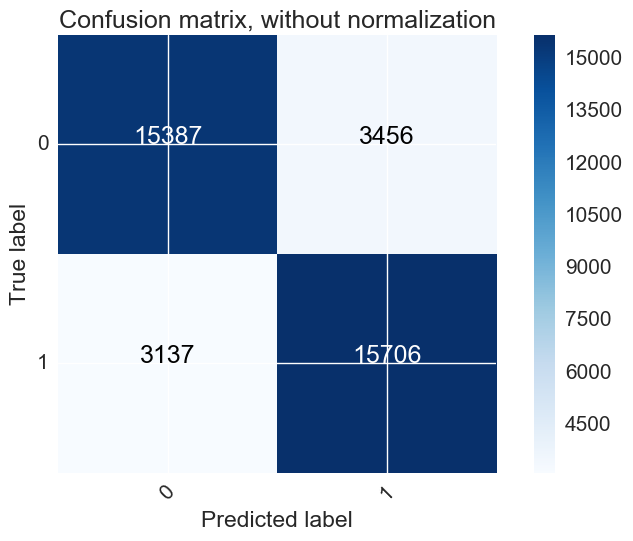

TP = 15706
FP = 3456
TN = 15387
FN = 3137
 
Precision ( or TPR) = 0.82
Specificity ( or TNR) = 0.82
Recall = 0.83
F1 = 0.83


In [121]:
custom_confusion_matrix(clf = gbc, x_data = xtrain_resampled, y_data = ytrain_resampled)

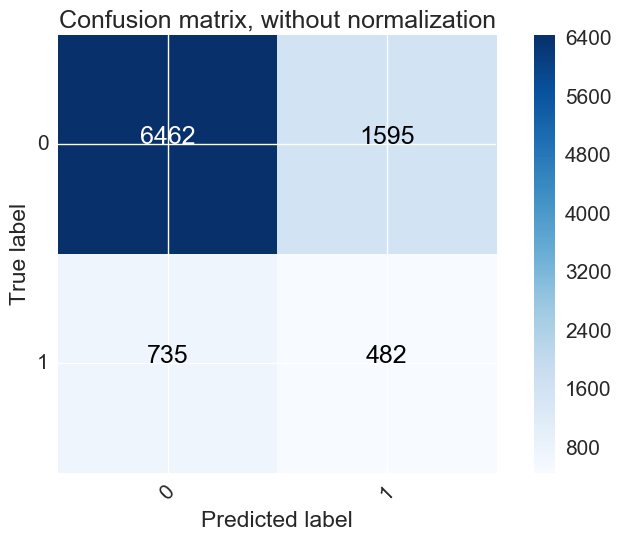

TP = 482
FP = 1595
TN = 6462
FN = 735
 
Precision ( or TPR) = 0.23
Specificity ( or TNR) = 0.8
Recall = 0.4
F1 = 0.29


In [122]:
custom_confusion_matrix(clf = gbc, x_data = xtest, y_data = ytest)

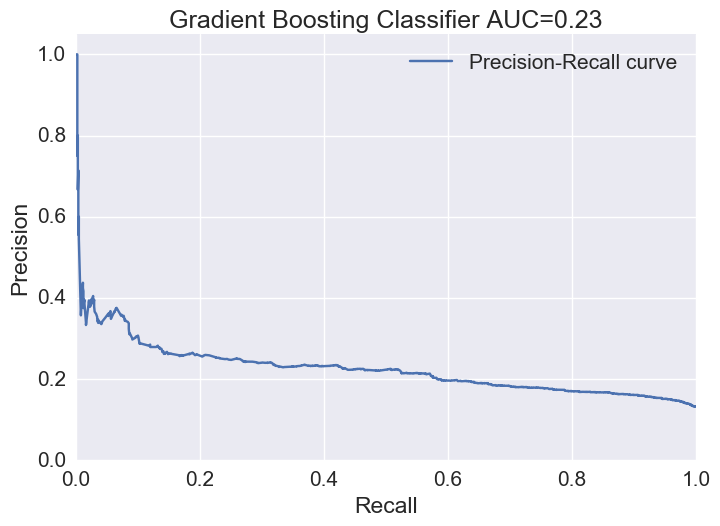

In [124]:
score(gbc, xtest, ytest, 'Gradient Boosting Classifier')

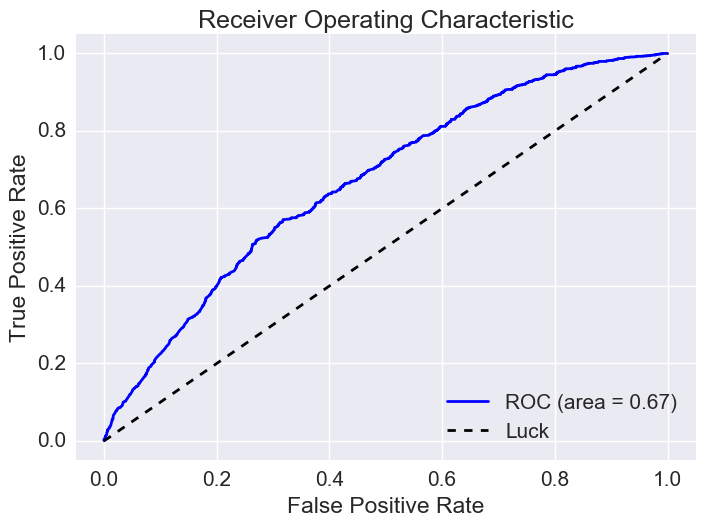

In [125]:
custom_roc(clf = gbc, x = xtest, y = ytest)

# Adaboost with resampled data

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# prepare a range of parameter values to test
parameters = {'base_estimator': [tree, forest],
              'n_estimators' : [10, 100, 500], 
              'learning_rate': sp_uniform_rand(0, 1)
             }

# create and fit a decision tree, testing each parameter with random samples
grid = RandomizedSearchCV(estimator = AdaBoostClassifier(random_state = 0), 
                          param_distributions = parameters,
                          scoring = scorer, 
                          cv = 5,
                          n_iter = 100)

grid = grid.fit(xtrain_resampled, ytrain_resampled)

# summarize the results of the grid search
print('Best score', str(round(grid.best_score_, 2)))
grid.best_params_

Fit classifier with best parameters. 

In [ ]:
adaboost = AdaBoostClassifier(**grid.best_params_)

adaboost.fit(xtrain_resampled, ytrain_resampled)

In [ ]:
custom_confusion_matrix(clf = adaboost, x = xtest, y = ytest)

In [ ]:
y_true = ytest
y_pred = adaboost.predict(xtest)

# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

TP = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[0][0]

Precision = TP / (TP + FP)
Specificity = TN / (TN + FP)
Recall = TP / (TP + FN)
F1 = 2*((Precision*Recall)/(Precision+Recall))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=[0,1], title='Confusion matrix, without normalization')
plt.show()

print("TP = {}".format(TP))
print("FP = {}".format(FP))
print("TN = {}".format(TN))
print("FN = {}".format(FN))
print(" ")
print('Precision ( or TPR) = {}'.format(round(Precision, 2)))
print('Specificity ( or TNR) = {}'.format(round(Specificity, 2)))
print('Recall = {}'.format(round(Recall, 2)))
print('F1 = {}'.format(round(F1 , 2)))

This one has a very low false positive rate.  
However, it also has a very low true positive rate.  
True negative rate on the other hand is excellent.  

In [ ]:
score(adaboost, xtest, ytest, 'Gradient Boosting Classifier')

In [ ]:
custom_roc(clf = adaboost, x = xtest, y = ytest)

# Ensemble

Now, let's take each of our best models and combine them such that the majority vote determines the final prediction for each company.  

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

estimators = []

#estimators.append(('KNN', knn))
estimators.append(('SVM', svm)) 
estimators.append(('DT', tree))
estimators.append(('RF', forest))
estimators.append(('GBC', gbc))
estimators.append(('AdaBoost', adaboost))

# create the ensemble model
ensemble = VotingClassifier(estimators, 
                            voting = 'soft',
                            weights = [1, 1, 1, 1, 1], # only used when voting = 'soft'
                            n_jobs = -1)

ensemble.fit(xtrain_resampled, ytrain_resampled)

In [ ]:
custom_confusion_matrix(clf = ensemble, x_data = xtest, y_data = ytest)

In [ ]:
score(ensemble, xtest, ytest, 'Ensemble')

In [ ]:
custom_roc(clf = ensemble, x = xtest, y = ytest)

# Evaluation

Alright, so our final model was an ensemble of KNN, SVM, Decision Tree, Random Forests, Gradient Boosted Trees and AdaBoost algorithms.  
We see that this does much better than our Multinomial Naive Bayes model in terms of precision and specificity.  
On the other hand, the recall score is much lower.  
Overall then, our F1 score remains unchanged.  

Let's try to figure out where our ensemble model is struggling exactly.  

In [ ]:
predictions = xtest.copy()
predictions = pd.DataFrame(data = predictions, 
                           columns = all_data.drop('status', axis = 1).columns.values)

def gather(df, key, value, cols):
    id_vars = [ col for col in df.columns if col not in cols ]
    id_values = cols
    var_name = key
    value_name = value
    return pd.melt( df, id_vars, id_values, var_name, value_name )


# gather dummified variables
predictions = gather(predictions, 'country_code', 'temp', [col for col in list(predictions) if col.startswith('country_code_')])
predictions = predictions[predictions.temp==1].drop('temp', axis = 1)

predictions = gather(predictions, 'category', 'temp', [col for col in list(predictions) if col.startswith('category_')])
predictions = predictions[predictions.temp==1].drop('temp', axis = 1)

# add true status
predictions['true_status'] = ytest

# add predicted status
predictions['predicted_status'] = ensemble.predict(X =  xtest)

predictions.head()

As we saw earlier, our recall score is the worst part of our model.  
Maybe, our model fails to predict a positive exit for companies in only certain categories? 

In [ ]:
temp = predictions.copy()

temp = temp[['category', 'true_status', 'predicted_status']]
temp = temp[temp.true_status==1]

temp = temp.groupby('category').sum().reset_index()
temp['prcnt_predicted'] = temp.predicted_status/temp.true_status
temp['prcnt_not_predicted'] = 1 - temp.prcnt_predicted

temp = temp.drop(['true_status', 'predicted_status'], axis = 1)
temp = temp.sort_values(by = 'prcnt_predicted')

temp.head()

In [ ]:
ax = temp.plot.barh(x = 'category', stacked=True)

ax.legend().set_visible(False)

ax.set_title("Exits Correctly Predicted by Category", fontweight = 'bold', fontsize = 15, position = [.5,1.05])
ax.set_ylabel("", fontsize = 12, fontstyle = 'italic')
ax.set_xlabel("", fontsize = 12, fontstyle = 'italic')

Seems we do bad across the board and in particular we fail to predict any security startup exits correctly.  

Is it companies that are not VC backed where we fail?


In [ ]:
temp = predictions.copy()

temp = temp[['top_vc_backed', 'true_status', 'predicted_status']]
temp['top_vc_backed'] = np.where(temp.top_vc_backed>0, 1, 0)
temp = temp[temp.true_status==1]

temp = temp.groupby('top_vc_backed').sum().reset_index()
temp['prcnt_predicted'] = temp.predicted_status/temp.true_status
temp['prcnt_not_predicted'] = 1 - temp.prcnt_predicted

temp = temp.drop(['true_status', 'predicted_status'], axis = 1)

temp.head()

In [ ]:
ax = temp.plot.barh(x = 'top_vc_backed', stacked=True)

ax.legend().set_visible(False)

ax.set_title("Exits Correctly Predicted by Category", fontweight = 'bold', fontsize = 15, position = [.5,1.05])
ax.set_ylabel("", fontsize = 12, fontstyle = 'italic')
ax.set_xlabel("", fontsize = 12, fontstyle = 'italic')

Is it certain funding categories where it fails? 

In [ ]:
temp = predictions.copy()

temp.total_raised_to_date.plot.hist()

In [ ]:
temp = predictions.copy()

temp['funding_category'] = '0'
temp['funding_category'][temp['total_raised_to_date'] > 100000000] = '>100M'
temp['funding_category'][(temp['total_raised_to_date'] > 100000000) & (temp['total_raised_to_date'] < 100000000)] = '>10M'
temp['funding_category'][(temp['total_raised_to_date'] > 50000000) & (temp['total_raised_to_date'] < 10000000)] = '>5M'
temp['funding_category'][(temp['total_raised_to_date'] > 25000000) & (temp['total_raised_to_date'] <  5000000)] = '>2.5M'
temp['funding_category'][(temp['total_raised_to_date'] > 0) & (temp['total_raised_to_date'] <  2500000)] = '>0'

temp = temp[['funding_category', 'true_status', 'predicted_status']]
temp = temp[temp.true_status==1]

temp = temp.groupby('funding_category').sum().reset_index()
temp['prcnt_predicted'] = temp.predicted_status/temp.true_status
temp['prcnt_not_predicted'] = 1 - temp.prcnt_predicted

temp = temp.drop(['true_status', 'predicted_status'], axis = 1)

temp.head()

In [ ]:
ax = temp.plot.barh(x = 'funding_category', stacked=True)

ax.legend().set_visible(False)

ax.set_title("Exits Correctly Predicted by Funding Category", fontweight = 'bold', fontsize = 15, position = [.5,1.05])
ax.set_ylabel("", fontsize = 12, fontstyle = 'italic')
ax.set_xlabel("", fontsize = 12, fontstyle = 'italic')

# Conclusions

Model is not yet performant enough for deployment. 

VCs are safe (for now). 

Potential improvements:

